# Problems

- For 50M training samples, we see a negative mse for the training set. This is wierd, as the training set should always have a positive mse.
- For 1M training samples, we see behavior as expected.

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["HF_HOME"] = "/workspace/julian/hf_cache"
import sys
sys.path.append("..")
from pathlib import Path
import torch as th
import numpy as np
from matplotlib import pyplot as plt
from tools.utils import CCLatent

chat_indices = th.load(Path("/workspace/data/only_it_decoder_feature_indices.pt"))

/tmp/ipykernel_34162/989592926.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chat_indices = th.load(Path("/workspace/data/only_it_decoder_feature_indices.pt"))


In [2]:
def to_array(df, skip_buckets = [0,4]):
    num_buckets = len(df["mean"][0].index)
    return np.stack([df["mean"][:, i].to_numpy() for i in range(num_buckets) if i not in skip_buckets])
    

def load_scalers(results_dir: Path, model_name: str, num_samples: int, n_offset: int = 0, special_results_dir: str = "", suffix: str = "", computation: str = "base_error", threshold_active_latents = None):
    if threshold_active_latents is not None:
        threshold_name = f"_jumprelu{threshold_active_latents}"
    else:
        threshold_name = ""
    if special_results_dir:
        scalers_path = results_dir / special_results_dir / model_name / f"betas_{computation}_N{num_samples}_n_offset{n_offset}{threshold_name}{suffix}.pt"
    else:
        scalers_path = results_dir / model_name / f"betas_{computation}_N{num_samples}_n_offset{n_offset}{threshold_name}{suffix}.pt"
    return th.load(scalers_path, weights_only=True)

def load_count_active(results_dir: Path, model_name: str, num_samples: int, n_offset: int = 0, special_results_dir: str = "", suffix: str = "", computation: str = "base_error", threshold_active_latents = None):
    if threshold_active_latents is not None:
        threshold_name = f"_jumprelu{threshold_active_latents}"
    else:
        threshold_name = ""
    if special_results_dir:
        count_active_path = results_dir / special_results_dir / model_name / f"count_active_{computation}_N{num_samples}_n_offset{n_offset}{threshold_name}{suffix}.pt"
    else:
        count_active_path = results_dir / model_name / f"count_active_{computation}_N{num_samples}_n_offset{n_offset}{threshold_name}{suffix}.pt"
    return th.load(count_active_path, weights_only=True)

def load_stats(results_dir: Path, model_name: str, num_samples: int, n_offset: int = 0, special_results_dir: str = "", suffix: str = "", sgd_name: str = "", computation: str = "base_error", threshold_active_latents = None):
    if threshold_active_latents is not None:
        threshold_name = f"_jumprelu{threshold_active_latents}"
    else:
        threshold_name = ""
    if special_results_dir:
        stats_path = results_dir / special_results_dir / model_name 
    else:
        stats_path = results_dir / model_name 

    if sgd_name:
        stats_path = stats_path /  f"stats_{computation}_sgd_{sgd_name}_N{num_samples}_n_offset{n_offset}{threshold_name}{suffix}.pt"
    else:
        stats_path = stats_path / f"stats_{computation}_N{num_samples}_n_offset{n_offset}{threshold_name}{suffix}.pt"
    return th.load(stats_path)

def get_latent_from_idx(idx, diff, return_latent: bool = True):
    if isinstance(diff, th.Tensor):
        diff = diff.cpu()
    nan_idx_to_original_idx = th.arange(len(diff))[~np.isnan(diff)]
    if return_latent:
        return CCLatent(chat_indices[nan_idx_to_original_idx[idx]].item())
    else:
        return nan_idx_to_original_idx[idx]

def plot_scalers_diff(betas, counts, name_a, name_b, relative: bool = False, log_scale_x: bool = False):
    if relative:
        diff = (betas[name_a] - betas[name_b]).abs() / th.max(betas[name_a], betas[name_b])
    else:
        diff = (betas[name_a] - betas[name_b]).abs()
    counts_a = counts[name_a]
    counts_b = counts[name_b]
    counts_a = counts_a[~th.isnan(diff)]
    counts_b = counts_b[~th.isnan(diff)]
    diff = diff[~th.isnan(diff)]

    
    print("Max diff:", diff.max().item(), " Counts:", counts_a[diff.argmax()].item(), counts_b[diff.argmax()].item(), "Max Act:", get_latent_from_idx(diff.argmax(), diff).max_act_unscaled)
    print("Median diff:", diff.median().item())
    print("Mean diff:", diff.mean().item())
    print("Min diff:", diff.min().item(), " Counts:", counts_a[diff.argmin()].item(), counts_b[diff.argmin()].item(), "Max Act:", get_latent_from_idx(diff.argmin(), diff).max_act_unscaled)
    if log_scale_x:
        diff = th.log(diff)
    plt.hist(diff.cpu().numpy(), bins=100)
    plt.xlabel("Absolute Difference in Beta Values")
    plt.ylabel("Count")
    plt.title(f"Distribution of Differences Between {name_a} and {name_b}")
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.show()


def to_array_fn(data):
    if isinstance(data, dict):
        return to_array(pd.DataFrame(data))
    else:
        return data

def plot_stats_buckets(stats, name, show_train: bool = True, show_val: bool = True):
    SAME_Y = True
    if show_train:
        mse_buckets_train = to_array_fn(stats[name + "-train"]["mse_buckets"]) 
        mse_buckets_before_train = to_array_fn(stats[name + "-train"]["mse_before_buckets"])
        perc_improvement_train = -(mse_buckets_train - mse_buckets_before_train) / mse_buckets_before_train

    mse_buckets_val = to_array_fn(stats[name + "-validation"]["mse_buckets"])
    mse_buckets_before_val = to_array_fn(stats[name + "-validation"]["mse_before_buckets"])
    perc_improvement_val = -(mse_buckets_val - mse_buckets_before_val) / mse_buckets_before_val

    if show_train:
        mse_buckets_train = to_array_fn(stats[name + "-train"]["mse_buckets"]) 
        mse_buckets_before_train = to_array_fn(stats[name + "-train"]["mse_before_buckets"])
        perc_improvement_train = -(mse_buckets_train - mse_buckets_before_train) / mse_buckets_before_train

    # Create histogram of differences between MSE buckets
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"MSE Percentage Improvement by Activation Bucket for {name}")

    # Get max count across all buckets for consistent y-axis
    max_count = 0
    for i in range(3):
        if show_train:
            counts_train, _ = np.histogram(perc_improvement_train[i][~np.isnan(perc_improvement_train[i])], bins=100)
            max_count = max(max_count, counts_train.max())
        if show_val:
            counts_val, _ = np.histogram(perc_improvement_val[i][~np.isnan(perc_improvement_val[i])], bins=100)
            max_count = max(max_count, counts_val.max())

    bucket_labels = ["0-33%", "33-66%", "66-100%"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        if show_val:
            plt.hist(perc_improvement_val[i][~np.isnan(perc_improvement_val[i])], bins=100, alpha=0.5, label='Validation', color='blue')
        if show_train:
            plt.hist(perc_improvement_train[i][~np.isnan(perc_improvement_train[i])], bins=100, alpha=0.5, label='Train', color='red')
        plt.title(f"Bucket {bucket_labels[i]}")
        plt.xlabel("Percentage Improvement")
        plt.ylabel("Count")
        plt.legend()
        if SAME_Y:
            plt.ylim(0, max_count*1.1)

    plt.tight_layout()
    plt.show()

def get_negative_improvement_features(stats, name, split, threshold: float = 0.0):
    """
    Calculate which features have negative percentage improvement across all buckets.
    
    Args:
        stats: Dictionary containing MSE statistics
        name: Name of the experiment
        
    Returns:
        numpy array: Boolean mask indicating which features have negative improvement in all buckets
    """
    mse_buckets = to_array_fn(stats[name + "-" + split]["mse_buckets"])
    mse_buckets_before = to_array_fn(stats[name + "-" + split]["mse_before_buckets"])
    perc_improvement = -(mse_buckets - mse_buckets_before) / mse_buckets_before
    

    mse_overall = to_array_fn(stats[name + "-" + split]["mse"])
    mse_before_overall = to_array_fn(stats[name + "-" + split]["mse_before"])
    perc_improvement_overall = -(mse_overall - mse_before_overall) / mse_before_overall

    # Check if improvement is negative across all buckets
    is_negative = np.ones(perc_improvement.shape[1], dtype=bool)
    for bucket in range(perc_improvement.shape[0]):
        is_negative &= (perc_improvement[bucket] < threshold) & ~np.isnan(perc_improvement[bucket])

    # Print features with negative improvement
    if np.any(is_negative):
        print(f"\nFeatures with negative improvement (below {threshold}):")
        negative_indices = np.where(is_negative)[0]
        # Sort indices by overall improvement
        sorted_indices = sorted(negative_indices, key=lambda idx: perc_improvement_overall[idx])
        for idx in sorted_indices:
            improvements = [perc_improvement[bucket][idx] for bucket in range(perc_improvement.shape[0])]
            print(f"Feature {idx}: Improvements across buckets = {[f'{x:.3f}' for x in improvements]}")
            print(f"Overall improvement: {perc_improvement_overall[idx]:.3f}")
    return is_negative


def plot_stats_mse(stats, name, show_train: bool = True, show_val: bool = True, threshold: float = -1e-3):
    if show_train:
        mse_train = to_array_fn(stats[name + "-train"]["mse"])
        mse_before_train = to_array_fn(stats[name + "-train"]["mse_before"])
        perc_improvement_train = -(mse_train - mse_before_train) / mse_before_train
        print(f"Train split has {np.sum((perc_improvement_train < threshold) & ~np.isnan(perc_improvement_train))} negative improvements")
        print(f"  Min:    {np.nanmin(perc_improvement_train).item():.5f}")
        print(f"  Max:    {np.nanmax(perc_improvement_train).item():.5f}")
        print(f"  Mean:   {np.nanmean(perc_improvement_train).item():.5f}")
        print(f"  Median: {np.nanmedian(perc_improvement_train).item():.5f}")

    if show_val:
        mse_val = to_array_fn(stats[name + "-validation"]["mse"])
        mse_before_val = to_array_fn(stats[name + "-validation"]["mse_before"])
        perc_improvement_val = -(mse_val - mse_before_val) / mse_before_val
        print(f"\nValidation split has {np.sum((perc_improvement_val < threshold) & ~np.isnan(perc_improvement_val))} negative improvements")
        print(f"  Min:    {np.nanmin(perc_improvement_val).item():.5f}")
        print(f"  Max:    {np.nanmax(perc_improvement_val).item():.5f}")
        print(f"  Mean:   {np.nanmean(perc_improvement_val).item():.5f}")
        print(f"  Median: {np.nanmedian(perc_improvement_val).item():.5f}")

    if show_train:
        plt.hist(perc_improvement_train, bins=100, alpha=0.5, label="Train", color="red")
    if show_val:
        plt.hist(perc_improvement_val, bins=100, alpha=0.5, label="Validation", color="blue")
    plt.xlabel("Percentage Improvement")
    plt.ylabel("Count")
    plt.title(f"Percentage Improvement for {name}")
    plt.legend()
    plt.show()


In [3]:
# Load all scalers

betas = {
    "50M": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 50_000_000, 0),
    "10M": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp"),
    "10M_fp64": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp", "_fp64"),
    "1M": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp"),
    "1M-shufflewithin": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, suffix="_shufflewithin"),
    "1M-1": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 1),
    "1M-2": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2),
    "chat-1M-2": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, computation="it_error"),
    "1M-2-jumprelu": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, threshold_active_latents=0.05),
    "1M-5epochs": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_stacked_5e"),
    "1M-10epochs": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_stacked_10e"),
    "500k-4": load_scalers(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 500_000, 4),
}

count_active = {
    "50M": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 50_000_000, 0),
    "10M": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp"),
    "1M": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp"),
    "1M-shufflewithin": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, suffix="_shufflewithin"),
    "1M-1": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 1),
    "1M-2": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2),
    "chat-1M-2": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, computation="it_error"),
    "1M-2-jumprelu": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, threshold_active_latents=0.05),
    "1M-5epochs": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_stacked_5e"),
    "1M-10epochs": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_stacked_10e"),
    "500k-4": load_count_active(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 500_000, 4),
}

stats = {
    "10M-train": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp", "_train"),
    "10M-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 10_000_000, 0, "tmp", "_validation"),
    "1M-train": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_train"),
    "1M-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, "tmp", "_validation"),
    "1M-2-train": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, suffix="_train"),
    "1M-2-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, suffix="_validation"),
    "chat-1M-2-train": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, suffix="_train", computation="it_error"),
    #"chat-1M-2-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, suffix="_validation", computation="it_error"),
    "1M-2-jumprelu-train": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, threshold_active_latents=0.05, suffix="_train"),
    "1M-2-jumprelu-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, threshold_active_latents=0.05, suffix="_validation"),
    "1M-2-val-1-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 2, suffix="_NT1000000_n_offset_train2_validation"),
    "sgd-ckp95k-validation": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, sgd_name="checkpoint_95000", suffix="_validation"),
    "sgd-ckp95k-train": load_stats(Path("/workspace/data/results/closed_form_scalars"), "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", 1_000_000, 0, sgd_name="checkpoint_95000", suffix="_train"),
}

/tmp/ipykernel_34162/145461951.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(stats_path)


In [4]:
perc_improvement_train = -(stats["1M-2-train"]["mse"] - stats["1M-2-train"]["mse_before"]) / stats["1M-2-train"]["mse_before"]
perc_improvement_val = -(stats["1M-2-validation"]["mse"] - stats["1M-2-validation"]["mse_before"]) / stats["1M-2-validation"]["mse_before"]

# remove nans
perc_improvement_train_no_nan = perc_improvement_train[~np.isnan(perc_improvement_train)]
perc_improvement_val_no_nan = perc_improvement_val[~np.isnan(perc_improvement_val)]

Train split has 0 negative improvements
  Min:    -0.00002
  Max:    0.11444
  Mean:   0.00491
  Median: 0.00021

Validation split has 1682 negative improvements
  Min:    -1.27071
  Max:    0.00015
  Mean:   -0.02125
  Median: -0.00209


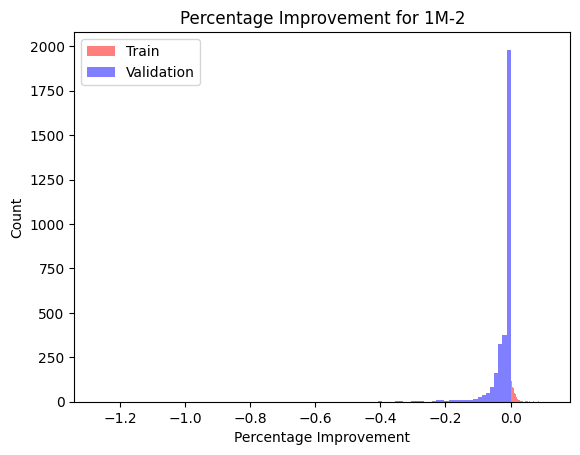

In [79]:
plot_stats_mse(stats, "1M-2", show_train=True, show_val=True)

Train split has 0 negative improvements
  Min:    -0.00003
  Max:    0.52862
  Mean:   0.02128
  Median: 0.00025

Validation split has 1577 negative improvements
  Min:    -1.31384
  Max:    0.00009
  Mean:   -0.06009
  Median: -0.00096


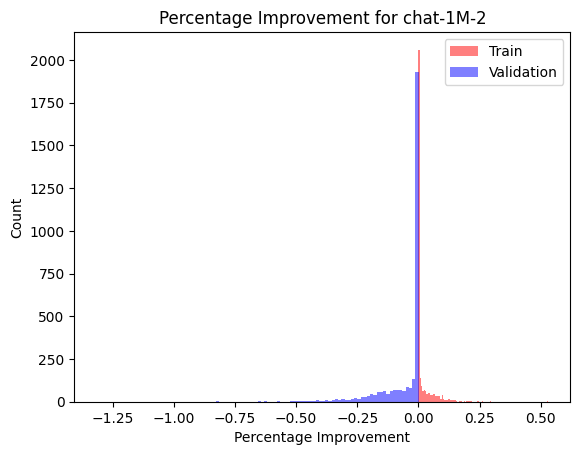

In [11]:
plot_stats_mse(stats, "chat-1M-2", show_train=True, show_val=True)

/tmp/ipykernel_103786/4222660993.py:46: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  nan_idx_to_original_idx = th.arange(len(diff))[~np.isnan(diff)]
/tmp/ipykernel_103786/4222660993.py:46: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  nan_idx_to_original_idx = th.arange(len(diff))[~np.isnan(diff)]


Max diff: 20357.830078125  Counts: 1.0 1.0 Max Act: 60.683594
Median diff: 12.31169319152832
Mean diff: 71.5814208984375
Min diff: 0.010591477155685425  Counts: 33306.0 33306.0 Max Act: 51.99224


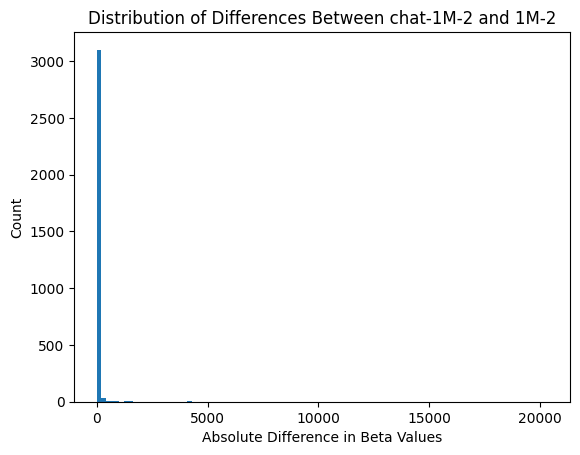

In [80]:
plot_scalers_diff(betas, count_active, "chat-1M-2", "1M-2")

Train split has 0 negative improvements
  Min:    -0.000
  Max:    0.114
  Mean:   0.005
  Median: 0.000

Validation split has 1632 negative improvements
  Min:    -1.220
  Max:    0.000
  Mean:   -0.020
  Median: -0.002


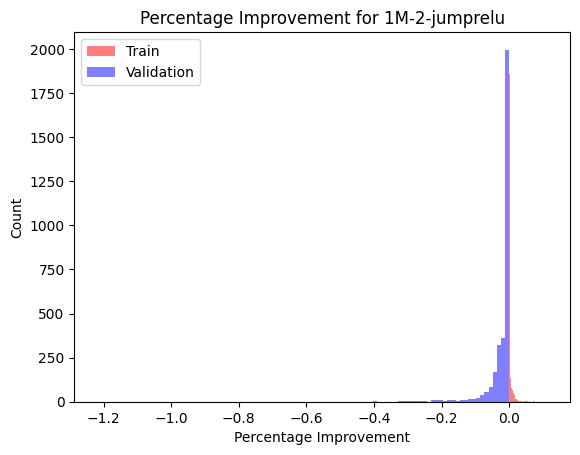

Train split has 0 negative improvements
  Min:    -0.000
  Max:    0.114
  Mean:   0.005
  Median: 0.000

Validation split has 1682 negative improvements
  Min:    -1.271
  Max:    0.000
  Mean:   -0.021
  Median: -0.002


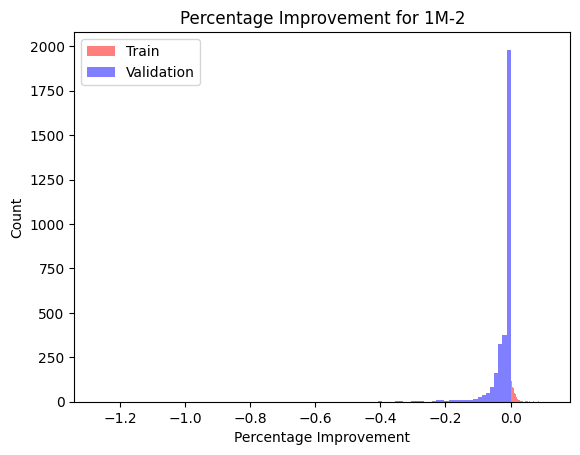

In [82]:
plot_stats_mse(stats, "1M-2-jumprelu", show_train=True, show_val=True)
plot_stats_mse(stats, "1M-2", show_train=True, show_val=True)

Train split has 0 negative improvements
  Min:    0.00000
  Max:    0.00024
  Mean:   0.00004
  Median: 0.00003

Validation split has 0 negative improvements
  Min:    -0.00000
  Max:    0.00025
  Mean:   0.00004
  Median: 0.00003


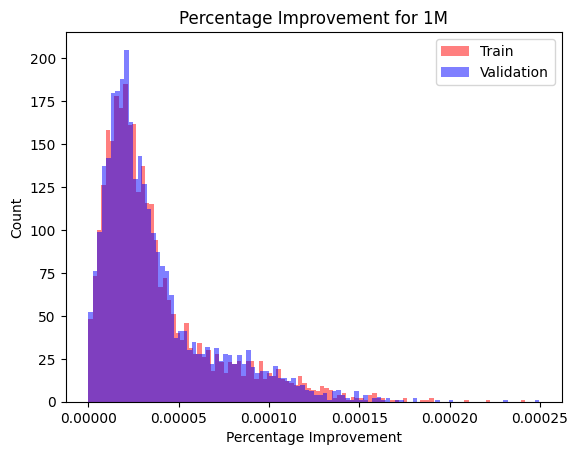

In [85]:
plot_stats_mse(stats, "1M", show_train=True, show_val=True)

Train split has 1252 negative improvements
  Min:    -0.93971
  Max:    0.00016
  Mean:   -0.00349
  Median: -0.00022

Validation split has 1259 negative improvements
  Min:    -0.92593
  Max:    0.00015
  Mean:   -0.00347
  Median: -0.00022


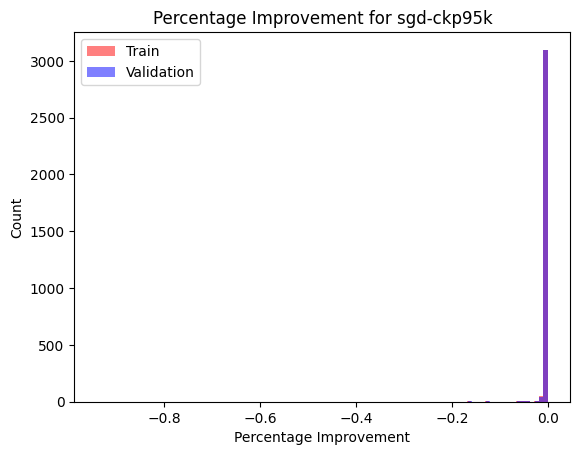

In [86]:
plot_stats_mse(stats, "sgd-ckp95k", show_train=True, show_val=True)

Train split has 0 negative improvements - Min: -2.451785324420268e-05, Max: 0.11443987892719204, Mean: 0.0049133013980512084, Median: 0.0002051230874177521
Validation split has 1682 negative improvements - Min: -1.270708004289767, Max: 0.00015284663406956115, Mean: -0.021246592229200233, Median: -0.002089057002425364


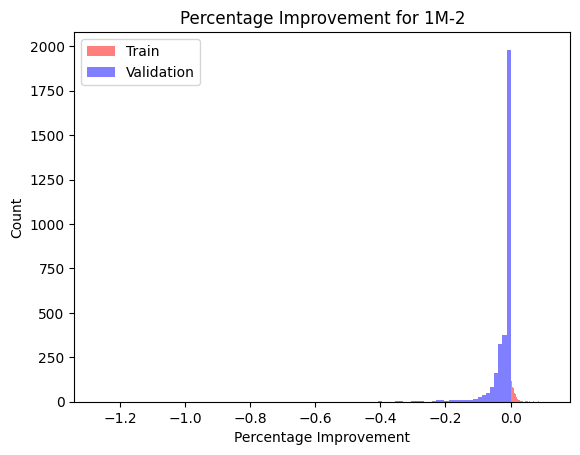

In [44]:
plot_stats_mse(stats, "1M-2", show_train=True, show_val=True)

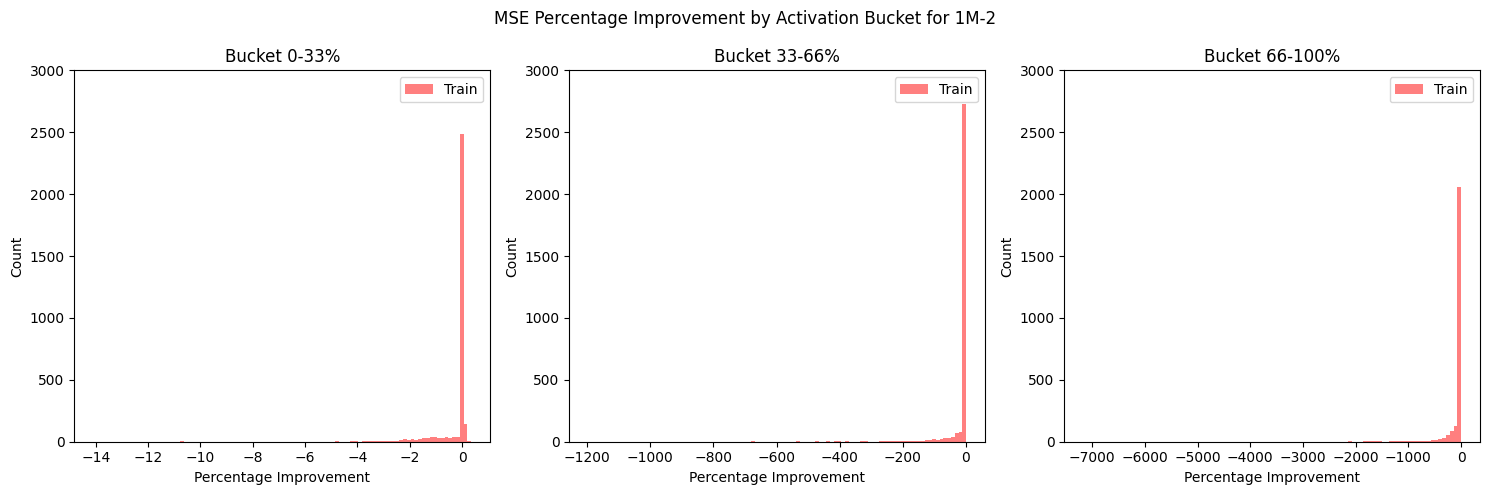

In [56]:
plot_stats_buckets(stats, "1M-2", show_train=True, show_val=False)

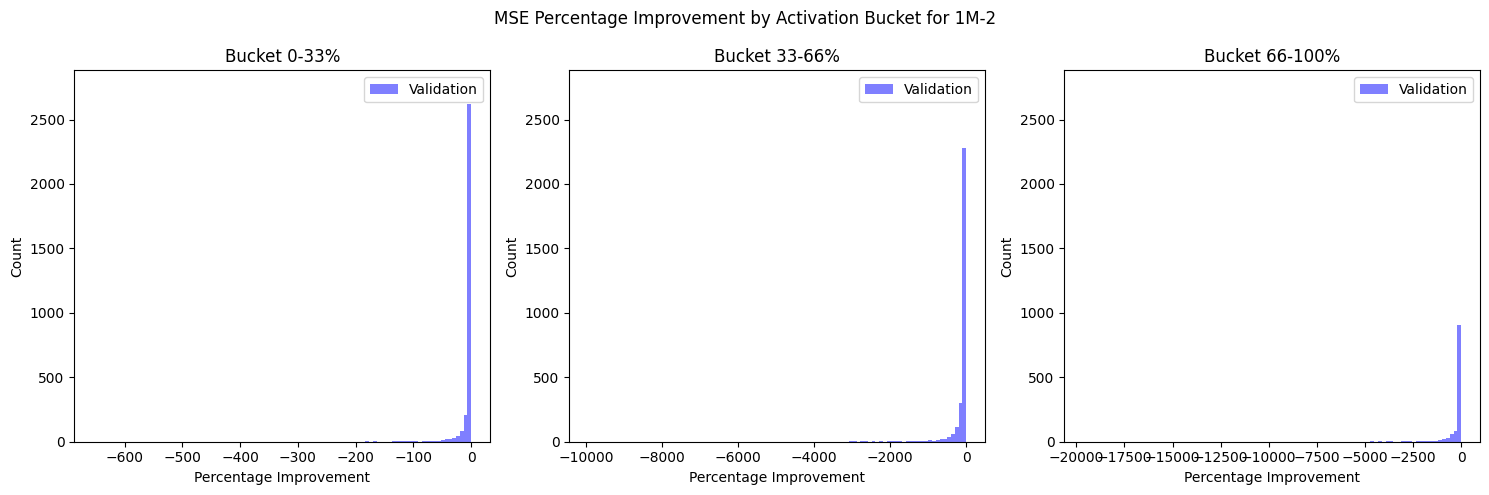

In [57]:
plot_stats_buckets(stats, "1M-2", show_train=False, show_val=True)

In [74]:
get_negative_improvement_features(stats, "1M-2-val-1", "validation", threshold=-1e-3).sum()


Features with negative improvement (below -0.001):
Feature 444: Improvements across buckets = ['-334.377', '-7483.310', '-25761.714']
Overall improvement: -0.799
Feature 2183: Improvements across buckets = ['-112.966', '-1572.948', '-3761.685']
Overall improvement: -0.592
Feature 81: Improvements across buckets = ['-177.364', '-2391.559', '-6641.912']
Overall improvement: -0.439
Feature 3024: Improvements across buckets = ['-105.587', '-1949.231', '-3841.526']
Overall improvement: -0.423
Feature 277: Improvements across buckets = ['-92.129', '-2370.805', '-5063.976']
Overall improvement: -0.405
Feature 3025: Improvements across buckets = ['-13.983', '-51.551', '-157.427']
Overall improvement: -0.355
Feature 1964: Improvements across buckets = ['-129.043', '-2716.459', '-8891.600']
Overall improvement: -0.346
Feature 1014: Improvements across buckets = ['-77.630', '-1074.508', '-3178.651']
Overall improvement: -0.299
Feature 1728: Improvements across buckets = ['-76.462', '-260.363', '

np.int64(789)

Train split has 1252 negative improvements - Min: -0.9397113419204814, Max: 0.0001639170774388427, Mean: -0.003485980380081707, Median: -0.00021592823575407305
Validation split has 1259 negative improvements - Min: -0.9259332615260752, Max: 0.00014671047205391013, Mean: -0.0034652819195990863, Median: -0.00022182415121461269


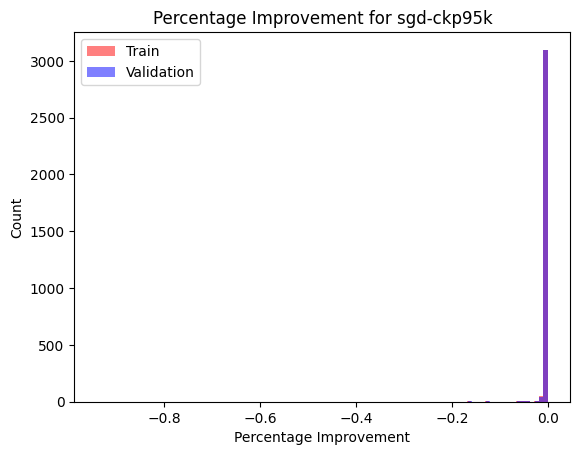

In [53]:
plot_stats_mse(stats, "sgd-ckp95k", show_train=True, show_val=True)

Train split has 0 negative improvements - Min: 6.888327427625214e-10, Max: 0.0002419217883050039, Mean: 3.772421335998357e-05, Median: 2.7148489325107524e-05
Validation split has 0 negative improvements - Min: -2.7144453485212863e-10, Max: 0.0002495161320612034, Mean: 3.7324898378484496e-05, Median: 2.741524364353469e-05


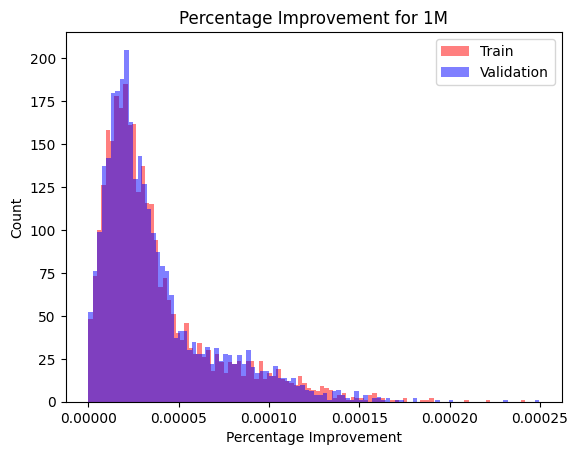

In [79]:
plot_stats_mse(stats, "1M")

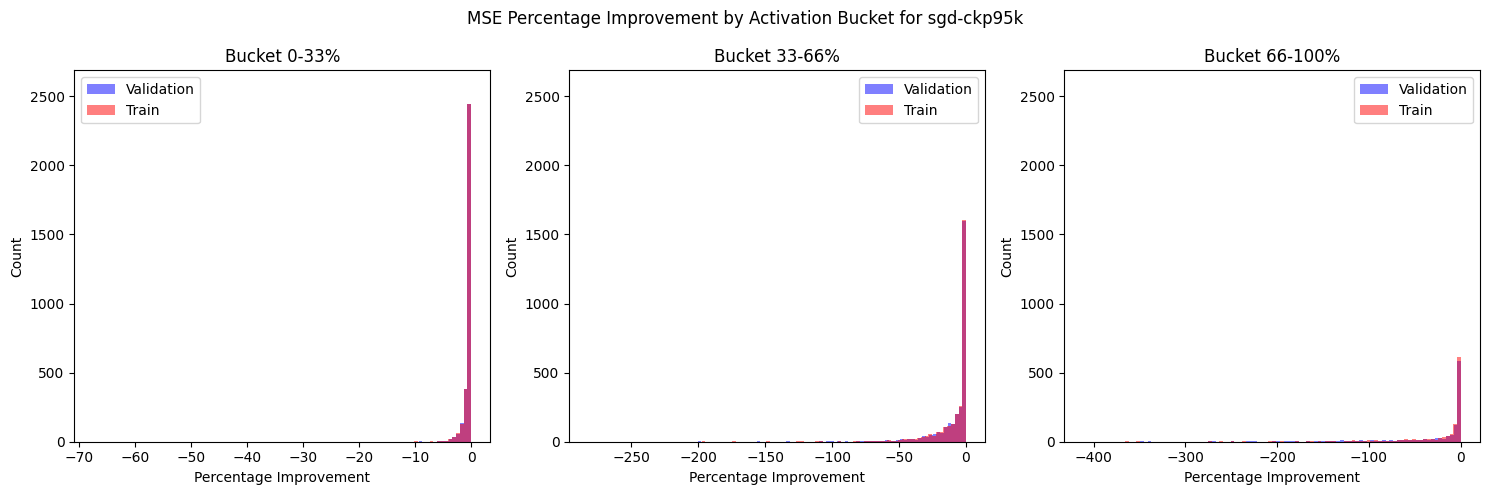

In [68]:
plot_stats_buckets(stats, "sgd-ckp95k")


## Comparison of scalers

Max diff: 2782.380859375  Counts: 1.0 1.0 Max Act: 60.683594
Median diff: 0.5491288900375366
Mean diff: 4.48284387588501
Min diff: 7.93561339378357e-05  Counts: 2921.0 5191.0 Max Act: 49.53558


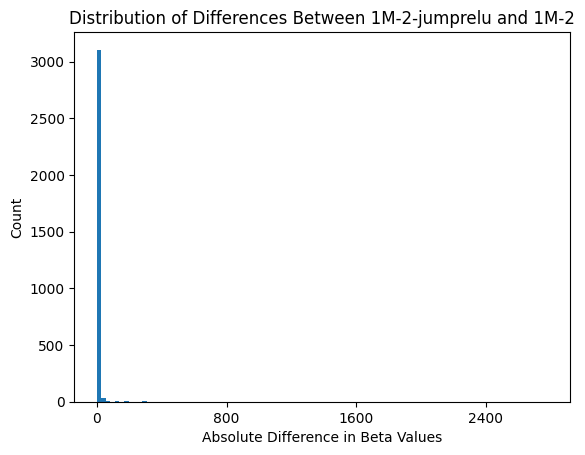

In [89]:
plot_scalers_diff(betas, count_active, "1M-2-jumprelu", "1M-2")

Max diff: 1254.718017578125  Counts: 2.0 918.0 Max Act: 49.39294
Median diff: 12.324371337890625
Mean diff: 24.65880012512207
Min diff: 0.00027954578399658203  Counts: 1820.0 2408.0 Max Act: 59.928158


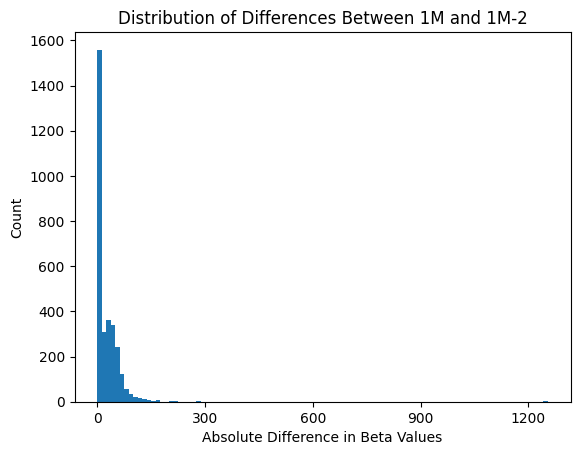

In [88]:
plot_scalers_diff(betas, count_active, "1M", "1M-2")

Max diff: 0.5590505599975586  Counts: 1689.0 1950.0 Max Act: 79.303894
Median diff: 0.03671765327453613
Mean diff: 0.04811568558216095
Min diff: 1.6450881958007812e-05  Counts: 6349.0 6817.0 Max Act: 56.14775


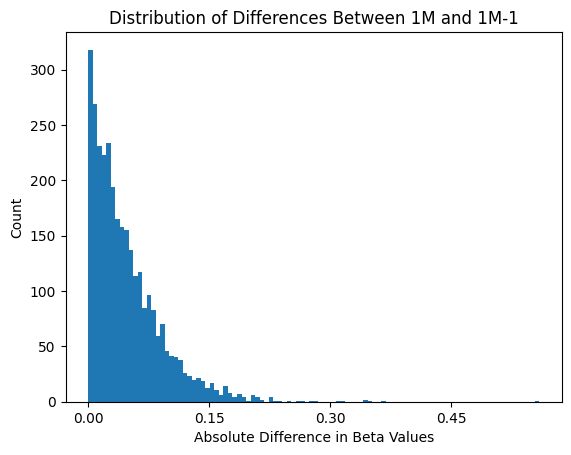

In [87]:
plot_scalers_diff(betas, count_active, "1M", "1M-1")

Max diff: 4698.565946696439  Counts: 8236.0 1095.0 Max Act: 41.999477
Median diff: 0.8192045604427101
Mean diff: 5.087680480930532
Min diff: 1.7164182599227473e-05  Counts: 25798.0 4734.0 Max Act: 59.525005


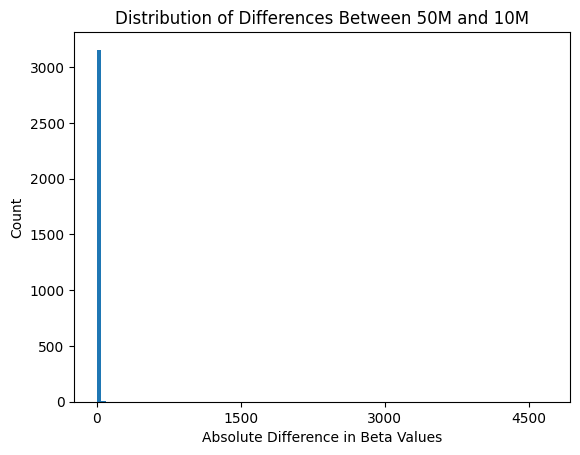

In [5]:
plot_scalers_diff(betas, count_active, "50M", "10M")

Max diff: 3996.358915446439  Counts: 8236.0 111.0 Max Act: 41.999477
Median diff: 1.0499391604071775
Mean diff: 7.651245077323261
Min diff: 0.0002531601844338871  Counts: 21993.0 381.0 Max Act: 57.39031


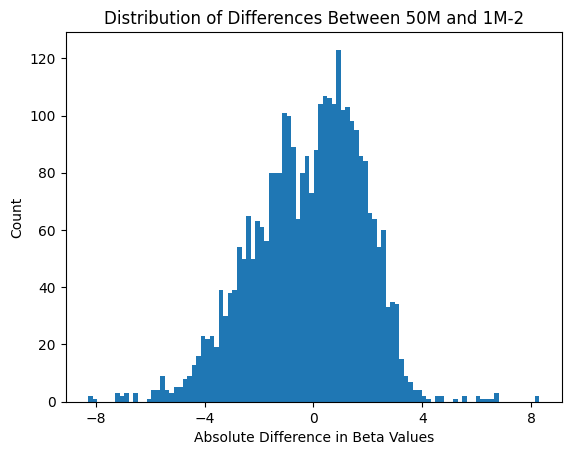

In [90]:
plot_scalers_diff(betas, count_active, "50M", "1M-2", log_scale_x=True)

Max diff: 0.00018167495727539062  Counts: 16439.0 82195.0 Max Act: 53.573845
Median diff: 7.152557373046875e-07
Mean diff: 1.640453433537914e-06
Min diff: 0.0  Counts: 4407.0 22035.0 Max Act: 39.83676


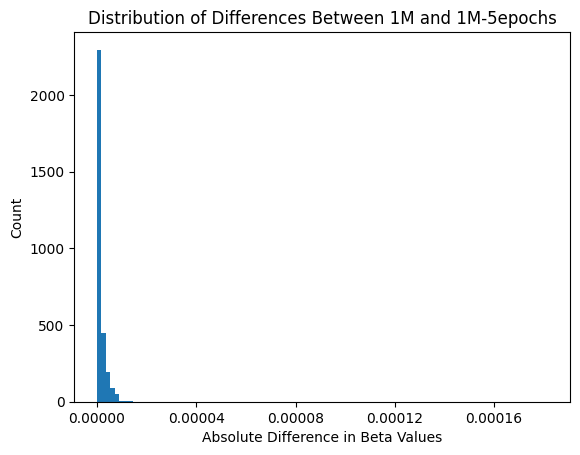

Max diff: 0.0003075599670410156  Counts: 16439.0 164390.0 Max Act: 53.573845
Median diff: 1.5497207641601562e-06
Mean diff: 3.8599114304815885e-06
Min diff: 0.0  Counts: 9248.0 92480.0 Max Act: 85.220856


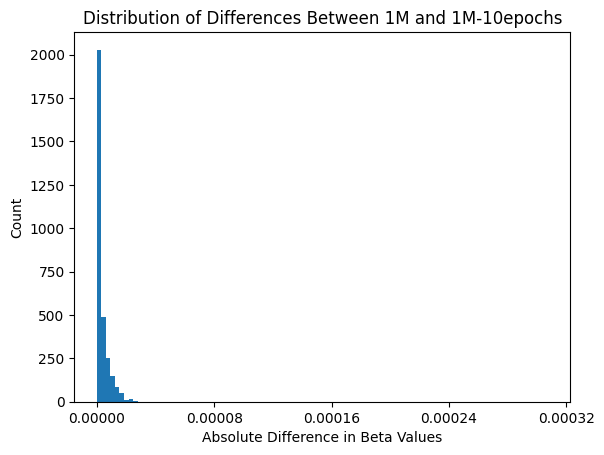

In [7]:
plot_scalers_diff(betas, count_active, "1M", "1M-5epochs")
plot_scalers_diff(betas, count_active, "1M", "1M-10epochs")


Max diff: 0.5590505599975586  Counts: 1689.0 1950.0 Max Act: 79.303894
Median diff: 0.03671765327453613
Mean diff: 0.04811568558216095
Min diff: 1.6450881958007812e-05  Counts: 6349.0 6817.0 Max Act: 56.14775


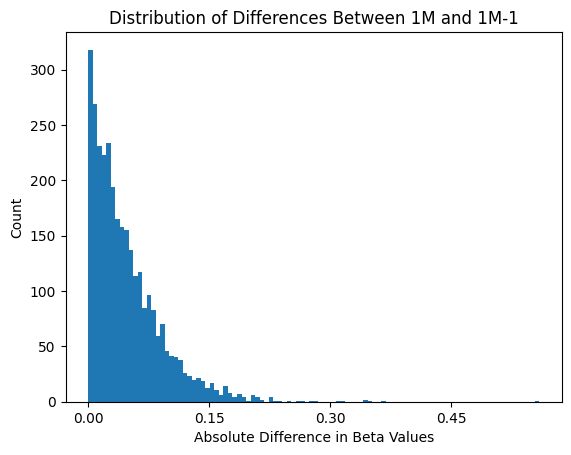

Max diff: 1254.718017578125  Counts: 2.0 918.0 Max Act: 49.39294
Median diff: 12.324371337890625
Mean diff: 24.65880012512207
Min diff: 0.00027954578399658203  Counts: 1820.0 2408.0 Max Act: 59.928158


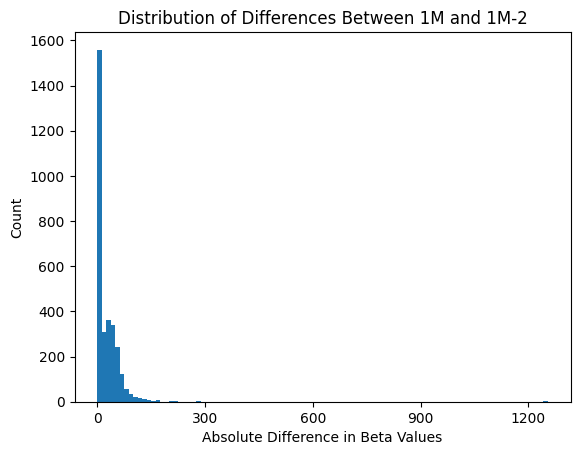

Max diff: 4.7326087951660156e-05  Counts: 16458.0 16458.0 Max Act: 65.31543
Median diff: 4.172325134277344e-07
Mean diff: 8.334044423463638e-07
Min diff: 0.0  Counts: 8318.0 8318.0 Max Act: 77.42117


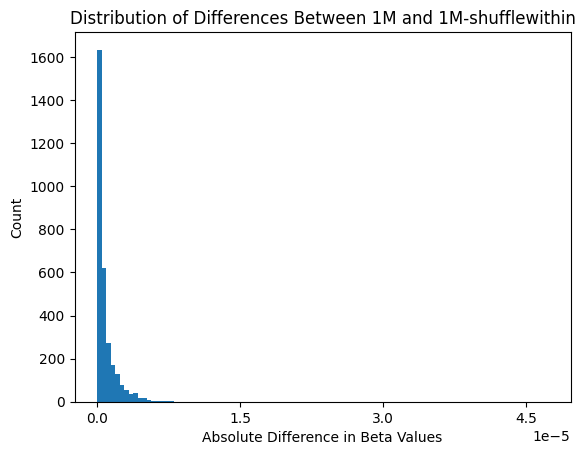

In [8]:
plot_scalers_diff(betas, count_active, "1M", "1M-1")
plot_scalers_diff(betas, count_active, "1M", "1M-2")
plot_scalers_diff(betas, count_active, "1M", "1M-shufflewithin")


# MSE improvement


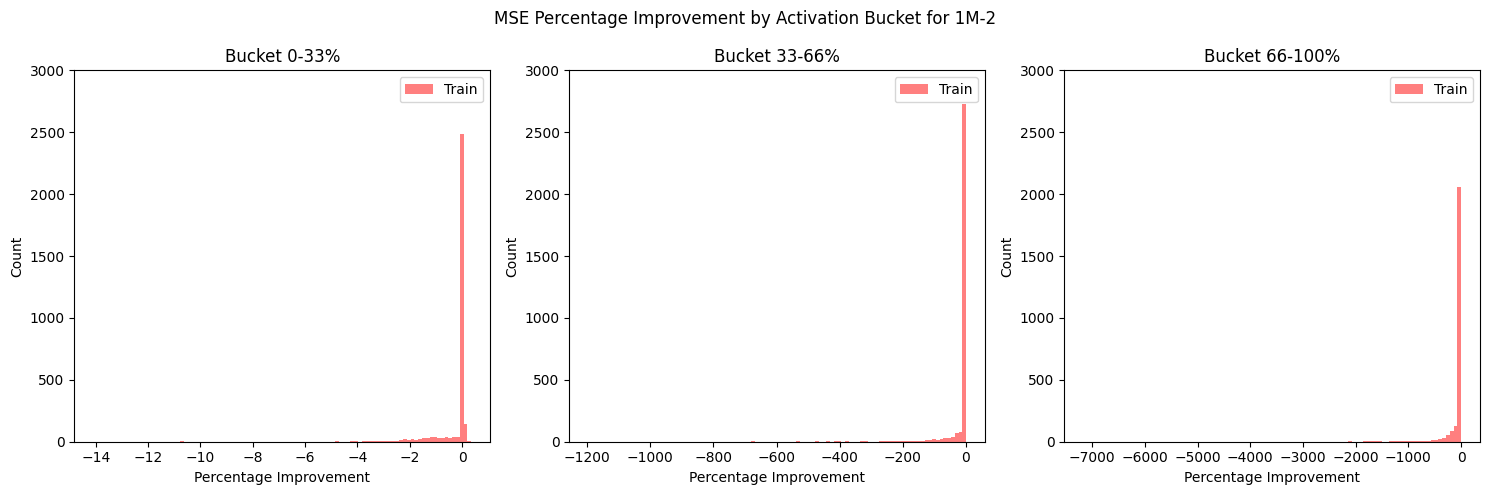

In [17]:
plot_stats_buckets(stats, "1M-2", show_val=False)

Train split has 0 negative improvements - Min: -2.451785324420268e-05, Max: 0.11443987892719204, Mean: 0.0049133013980512084, Median: 0.0002051230874177521
Validation split has 1682 negative improvements - Min: -1.270708004289767, Max: 0.00015284663406956115, Mean: -0.021246592229200233, Median: -0.002089057002425364


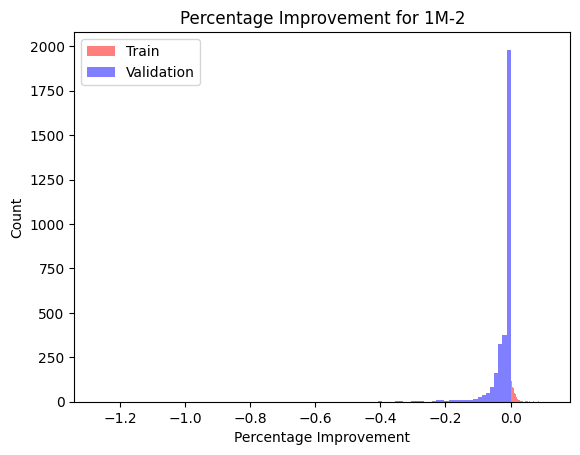

In [61]:
plot_stats_mse(stats, "1M-2")

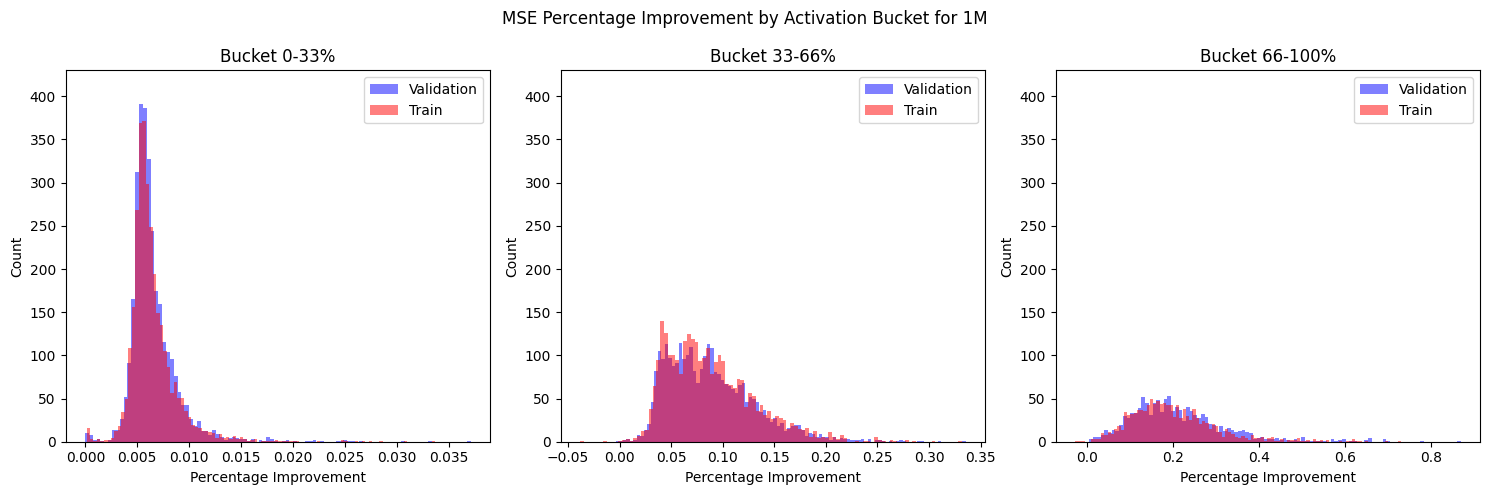

In [10]:
plot_stats_buckets(stats, "1M")

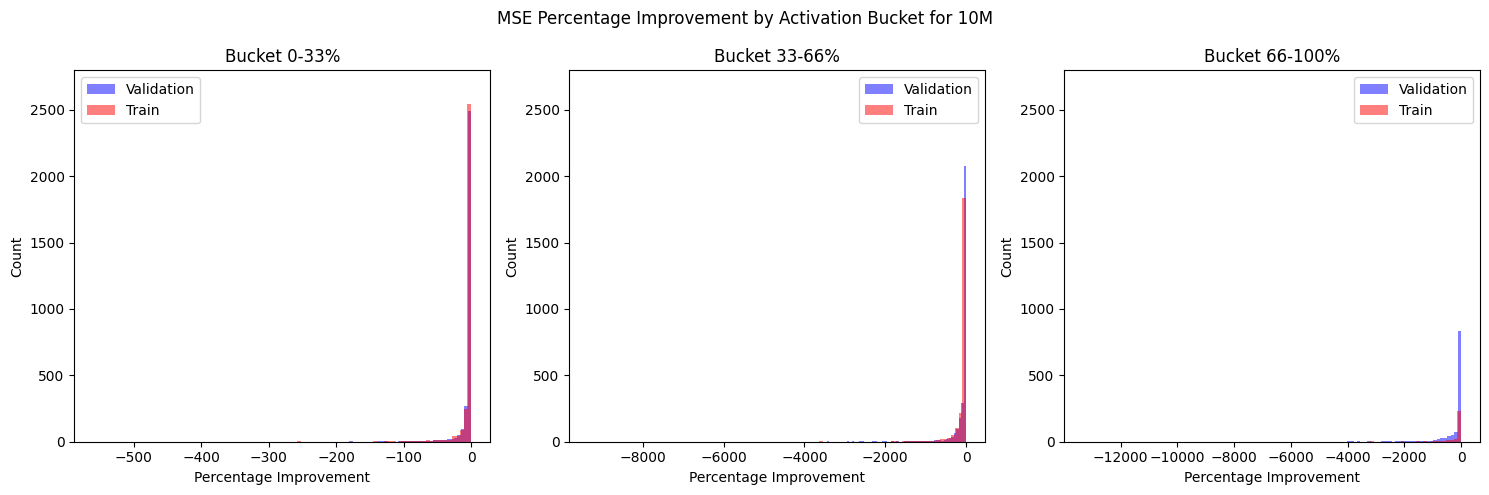

In [32]:
plot_stats_buckets(stats, "10M")

# SGD - Closed Form Correlation

In [63]:
sgd_betas = th.load("/workspace/data/checkpoints/feature_scaler/L13-mu0.0e+00-lr1e-03-s42-Individual-alllatents/checkpoint_95000.pt")["scaler"]
cf_betas = betas["50M"]
cf_betas.shape, sgd_betas.shape


/tmp/ipykernel_46601/3943720031.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sgd_betas = th.load("/workspace/data/checkpoints/feature_scaler/L13-mu0.0e+00-lr1e-03-s42

(torch.Size([3176]), torch.Size([3176]))

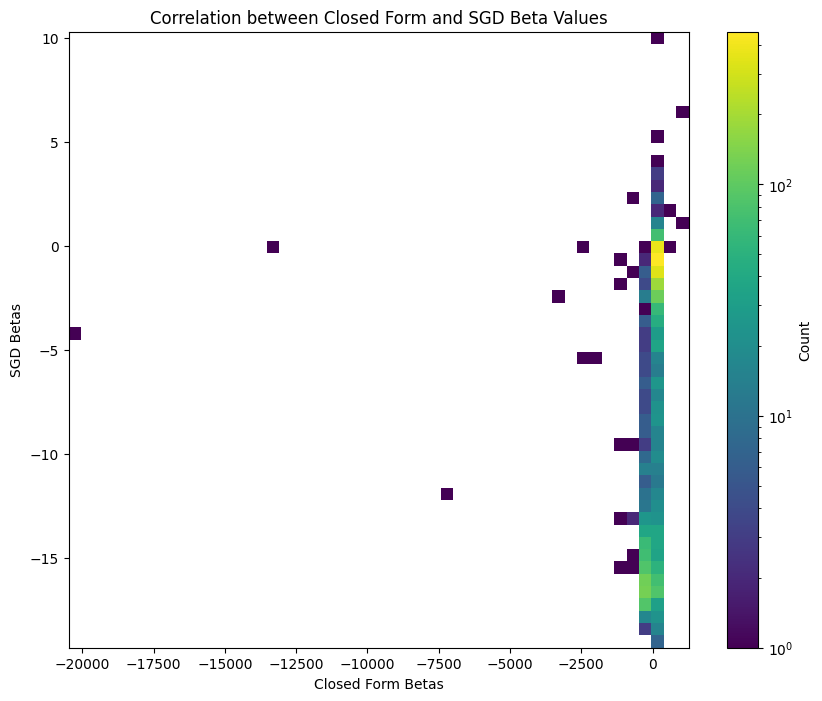

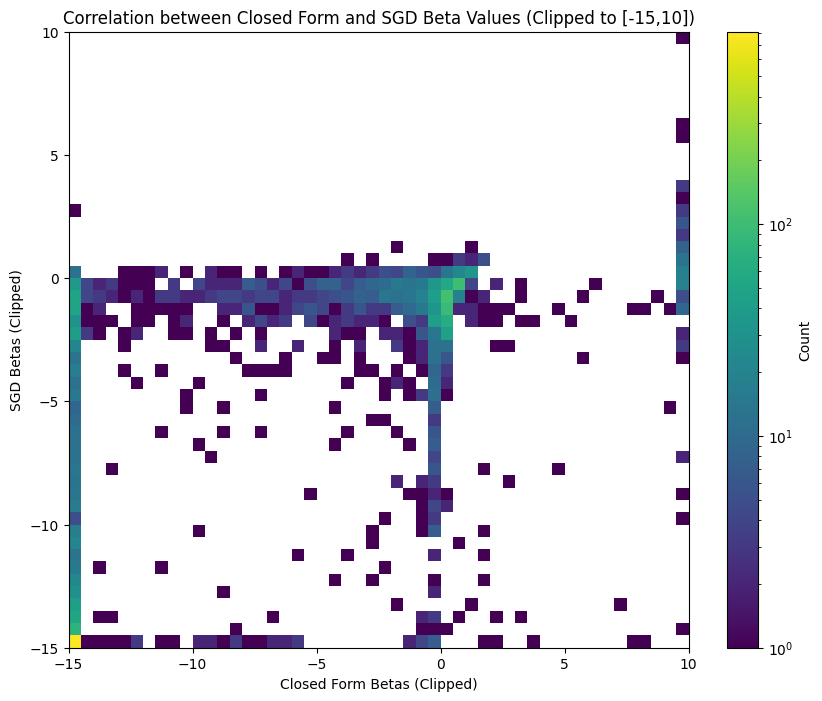

In [68]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(10,8))
# Convert to numpy and remove NaN values
cf_np = cf_betas.cpu().numpy()
sgd_np = sgd_betas.cpu().numpy()
mask = ~np.isnan(cf_np) & ~np.isnan(sgd_np)
cf_clean = cf_np[mask]
sgd_clean = sgd_np[mask]

plt.hist2d(cf_clean, sgd_clean, bins=50, cmap='viridis', norm=LogNorm())
plt.colorbar(label='Count')
plt.xlabel('Closed Form Betas')
plt.ylabel('SGD Betas')
plt.title('Correlation between Closed Form and SGD Beta Values')
plt.show()


# Create second plot with clipped values
plt.figure(figsize=(10,8))

# Clip values to [-15, 10] range
cf_clipped = np.clip(cf_clean, -15, 10)
sgd_clipped = np.clip(sgd_clean, -15, 10)

plt.hist2d(cf_clipped, sgd_clipped, bins=50, cmap='viridis', norm=LogNorm(), 
           range=[[-15, 10], [-15, 10]])
plt.colorbar(label='Count')
plt.xlabel('Closed Form Betas (Clipped)')
plt.ylabel('SGD Betas (Clipped)') 
plt.title('Correlation between Closed Form and SGD Beta Values (Clipped to [-15,10])')
plt.show()


In [73]:
# Compute Pearson correlation coefficient and p-value between closed form and SGD betas
from scipy import stats
correlation, p_value = stats.pearsonr(cf_clean, sgd_clean)
print(f"Pearson correlation coefficient between closed form and SGD betas: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")

# Also compute correlation and p-value for clipped values
correlation_clipped, p_value_clipped = stats.pearsonr(cf_clipped, sgd_clipped)
print(f"Pearson correlation coefficient between clipped closed form and SGD betas: {correlation_clipped:.4f}")
print(f"P-value (clipped): {p_value_clipped:.4e}")


Pearson correlation coefficient between closed form and SGD betas: 0.0473
P-value: 7.7985e-03
Pearson correlation coefficient between clipped closed form and SGD betas: 0.6943
P-value (clipped): 0.0000e+00


# Identifying what happens during computation

We look at the MSE for each training sample for the overfit latent on the overfit dataset and compare this to the non-overfit dataset. 

We plot MSE with scaler - MSE without scaler. A positive value means the scalers make the reconstruction worse. A negative one makes the reconstruction better

In [5]:
def plot_mse_diff(stats, name, ylog: bool = False, idx: int = 0):
    mse_diff = (stats["mse_individual"] - stats["mse_before_individual"])[idx]
    # Calculate summary statistics for MSE differences
    min_diff = mse_diff.min().item()
    max_diff = mse_diff.max().item()
    mean_diff = mse_diff.mean().item()
    median_diff = float(np.median(mse_diff))
    # Count number of positive, negative and zero differences
    n_neg = (mse_diff < 0).sum().item()
    n_pos = (mse_diff > 0).sum().item() 
    n_zero = (mse_diff == 0).sum().item()
    
    print("MSE Difference Counts")
    print("--------------------------------")
    print(f"Negative: {n_neg:>12,d}")
    print(f"Positive: {n_pos:>12,d}")
    print(f"Zero:     {n_zero:>12,d}")
    print("--------------------------------")
    print("\nMSE Difference Summary Statistics")
    print("--------------------------------")
    print(f"Minimum:  {min_diff:>12,.2f}")
    print(f"Maximum:  {max_diff:>12,.2f}")
    print(f"Mean:     {mean_diff:>12,.2f}")
    print(f"Median:   {median_diff:>12,.2f}")
    print("--------------------------------")
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(mse_diff)), mse_diff, alpha=0.5, s=1)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.xlabel('Sample index')
    plt.ylabel('MSE difference')
    plt.title(f'MSE Difference per Sample for Overfit Latent on {name} Dataset (mse_with_scaler - mse_without_scaler)')
    if ylog:
        plt.yscale('log')
    plt.show()

In [6]:
top10_train = th.tensor(perc_improvement_train_no_nan).topk(10).indices
top10_train_indices = [get_latent_from_idx(top10_train[i], perc_improvement_train, return_latent=False).item() for i in range(10)]
top10_train_latent_indices = [get_latent_from_idx(top10_train[i], perc_improvement_train, return_latent=True).id for i in range(10)]
for idx in top10_train_indices:
    print(perc_improvement_train[idx], perc_improvement_val[idx])
# th.save(th.tensor(top10_train_indices), "/workspace/data/top10_train_mse_indices_overfit_1M-2.pt")

0.11443987892719204 -0.22997316410008903
0.10783948652847238 -0.11462718049837972
0.10705706301279386 -0.4062447303993392
0.10358023965342832 -0.4905976307698941
0.09490710300082857 -0.04555607393718376
0.08960092796713062 -0.11186012050383155
0.08799128629227258 -0.1773685383105697
0.08625366331718048 -0.05179316122607543
0.08570652432518015 -0.07156162561769584
0.08533637374557992 -0.20453188907249956


In [7]:
for idx in range(len(top10_train_indices)):
    print(f"Latent Index: {top10_train_latent_indices[idx]}, Beta Overfit Subset (1M-2): {betas['1M-2'][top10_train_indices[idx]].item():.4f}, Beta Non-overfit Subset (1M): {betas['1M'][top10_train_indices[idx]].item():.4f}")

Latent Index: 53551, Beta Overfit Subset (1M-2): -123.7400, Beta Non-overfit Subset (1M): 1.0507
Latent Index: 49037, Beta Overfit Subset (1M-2): -102.4087, Beta Non-overfit Subset (1M): 0.7946
Latent Index: 22946, Beta Overfit Subset (1M-2): -166.3950, Beta Non-overfit Subset (1M): 0.5737
Latent Index: 48802, Beta Overfit Subset (1M-2): -123.5979, Beta Non-overfit Subset (1M): 0.3595
Latent Index: 45142, Beta Overfit Subset (1M-2): 58.5288, Beta Non-overfit Subset (1M): 1.3773
Latent Index: 64002, Beta Overfit Subset (1M-2): -92.5706, Beta Non-overfit Subset (1M): 0.3586
Latent Index: 51124, Beta Overfit Subset (1M-2): 90.8980, Beta Non-overfit Subset (1M): 1.4073
Latent Index: 38421, Beta Overfit Subset (1M-2): -71.7770, Beta Non-overfit Subset (1M): 0.4493
Latent Index: 60975, Beta Overfit Subset (1M-2): -105.1173, Beta Non-overfit Subset (1M): 0.4923
Latent Index: 27793, Beta Overfit Subset (1M-2): -116.4076, Beta Non-overfit Subset (1M): 0.5763


In [8]:
from pathlib import Path

base_path = Path("/workspace/data/results/closed_form_scalars/Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04")

overfit_ds = th.load(base_path / "stats_base_error_N1000000_n_offset2_subset_top10_train_mse_indices_overfit_1M-2_train.pt")
nonoverfit_ds = th.load(base_path / "stats_base_error_N1000000_n_offset0_subset_top10_train_mse_indices_overfit_1M-2_train.pt")
combined_ds = th.load(base_path / "stats_base_error_N3000000_n_offset0_subset_top10_train_mse_indices_overfit_1M-2_train.pt")
overfit_ds_chat = th.load(base_path / "stats_it_error_N1000000_n_offset2_subset_top10_train_mse_indices_overfit_1M-2_train.pt")

/tmp/ipykernel_34162/2941129156.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  overfit_ds = th.load(base_path / "stats_base_error_N1000000_n_offset2_subset_top10_train_

In [58]:
recomputed_combined_ds = th.load("/workspace/data/results/closed_form_scalars/ood/Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04/stats_base_error_N5000000_n_offset0_subset_top10_train_mse_indices_overfit_1M-2_train.pt")

/tmp/ipykernel_34162/1131342485.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recomputed_combined_ds = th.load("/workspace/data/results/closed_form_scalars/ood/Butaniu

MSE Difference Counts
--------------------------------
Negative:          182
Positive:       42,380
Zero:        4,957,438
--------------------------------

MSE Difference Summary Statistics
--------------------------------
Minimum:       -243.38
Maximum:  4,992,542.00
Mean:         1,171.25
Median:           0.00
--------------------------------


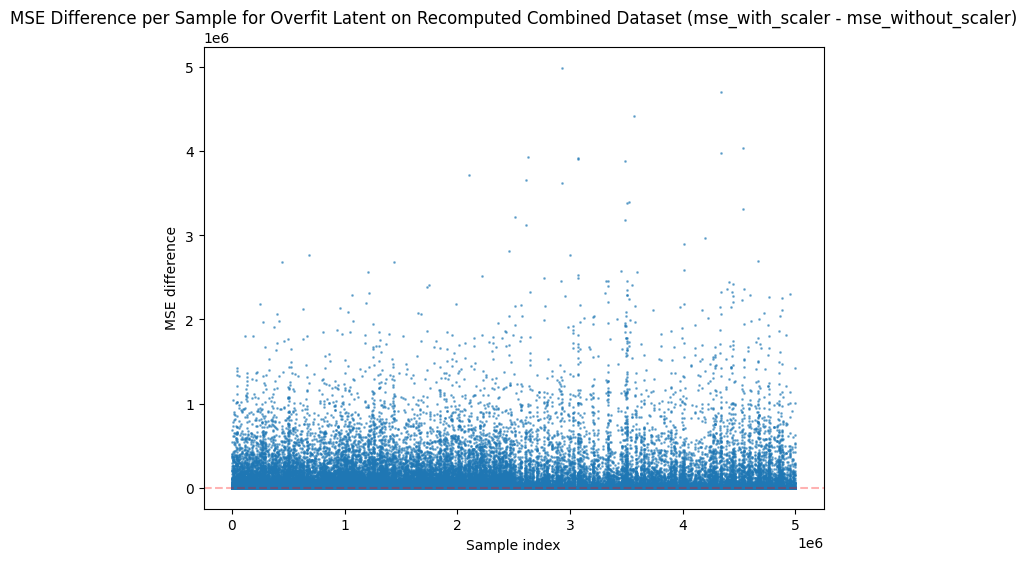

In [59]:
plot_mse_diff(recomputed_combined_ds, "Recomputed Combined", idx=0)

MSE Difference Counts
--------------------------------
Negative:        1,001
Positive:       10,910
Zero:          988,089
--------------------------------

MSE Difference Summary Statistics
--------------------------------
Minimum:  -21,375,480.00
Maximum:  4,947,796.00
Mean:       -10,420.93
Median:           0.00
--------------------------------


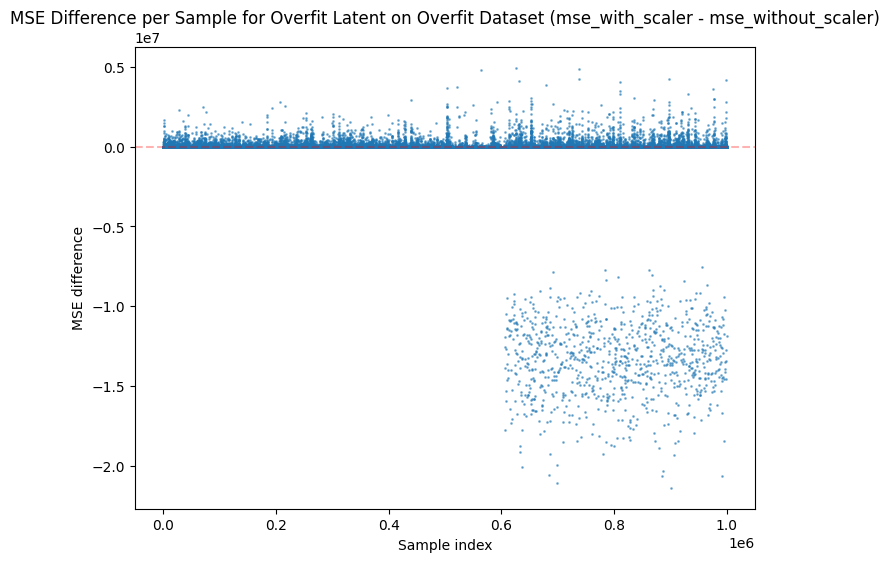

In [29]:
plot_mse_diff(overfit_ds, "Overfit", idx=0)

MSE Difference Counts
--------------------------------
Negative:        7,272
Positive:        1,554
Zero:          991,174
--------------------------------

MSE Difference Summary Statistics
--------------------------------
Minimum:       -796.84
Maximum:         90.61
Mean:            -0.25
Median:           0.00
--------------------------------


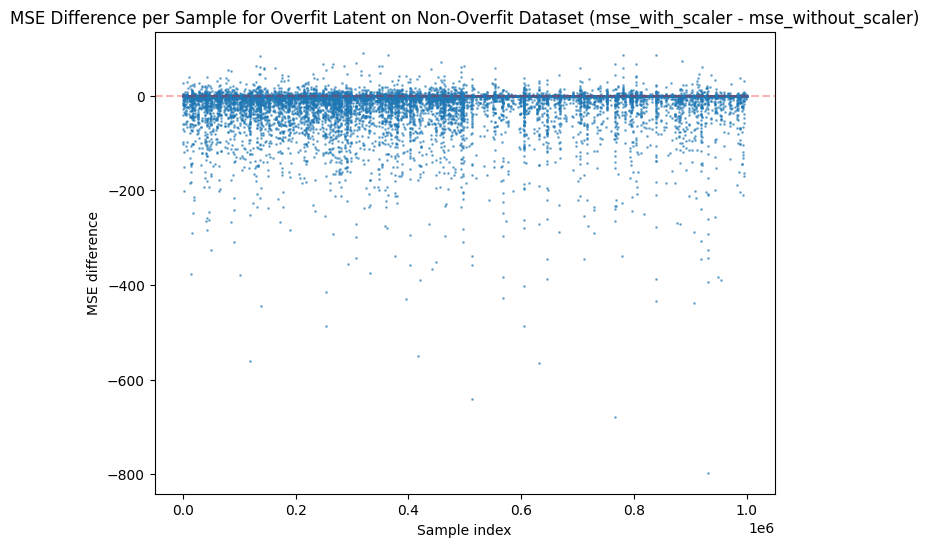

In [30]:
plot_mse_diff(nonoverfit_ds, "Non-Overfit")

MSE Difference Counts
--------------------------------
Negative:        1,109
Positive:       27,675
Zero:        2,971,216
--------------------------------

MSE Difference Summary Statistics
--------------------------------
Minimum:  -19,858,352.00
Maximum:  3,611,883.25
Mean:        -2,805.21
Median:           0.00
--------------------------------


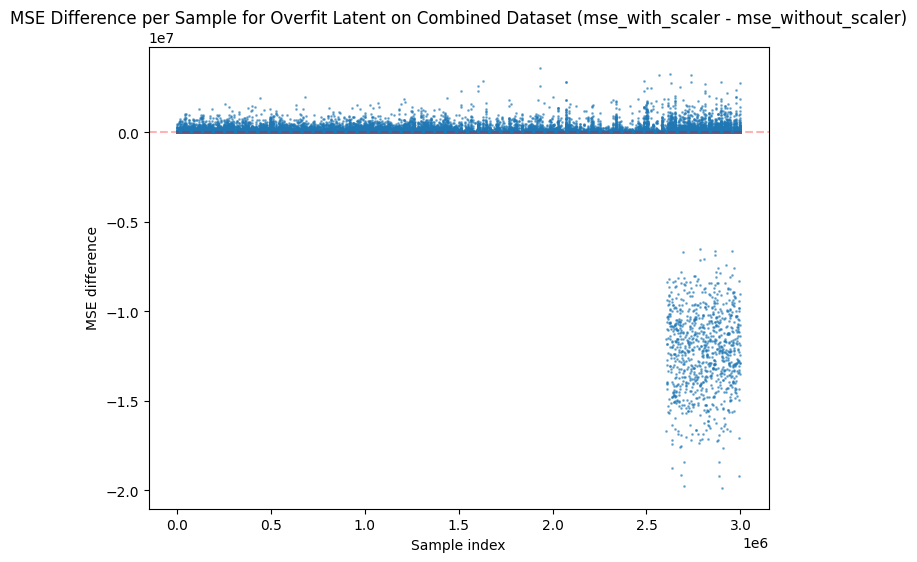

In [13]:
plot_mse_diff(combined_ds, "Combined", idx=0)

In [9]:
overfit_ds_chat.keys()

dict_keys(['mse_buckets', 'mse_before_buckets', 'bucket_edges', 'mse_individual', 'mse_before_individual', 'mse_mean', 'mse_std', 'mse_count', 'mse_before_mean', 'mse_before_std', 'mse_before_count'])

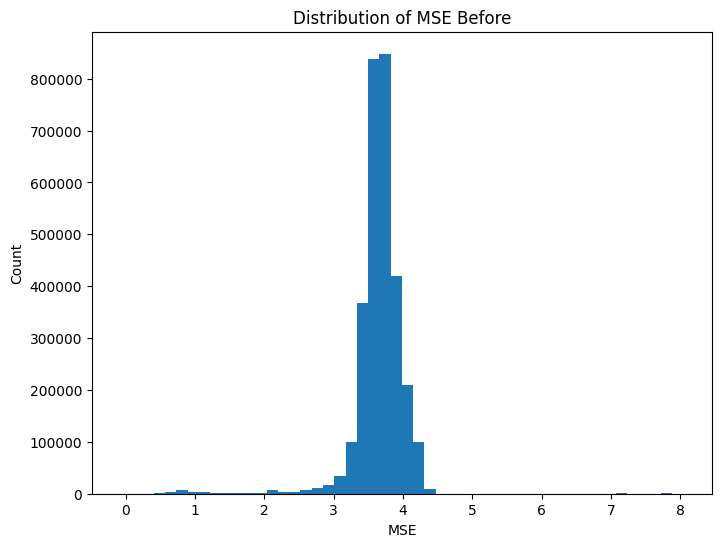

In [15]:
plt.figure(figsize=(8, 6))
plt.hist(np.log10(combined_ds["mse_before_individual"][0]), bins=50)
plt.title('Distribution of MSE Before')
plt.xlabel('MSE')
plt.ylabel('Count')

plt.show()


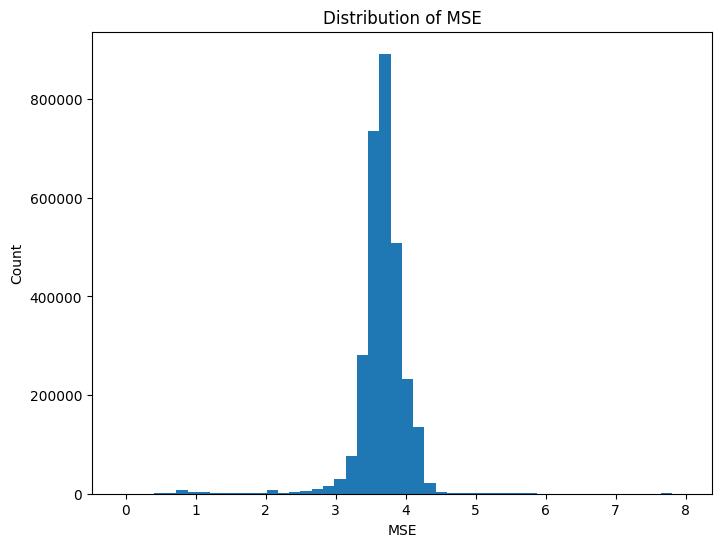

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(np.log10(combined_ds["mse_individual"][0]), bins=50)
plt.title('Distribution of MSE')
plt.xlabel('MSE')
plt.ylabel('Count')

plt.show()


In [53]:
plot_mse_diff(overfit_ds_chat, "Overfit Chat")

KeyError: 'mse_individual'

### Let's look at the tokens

In [87]:
from transformers import AutoTokenizer
from tools.utils import load_activation_dataset
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

_, lmsys_cache = load_activation_dataset(
    "/workspace/data/activations/",
    layer=13,
    split="train",
)

Loading fineweb cache from /workspace/data/activations/gemma-2-2b/fineweb-1m-sample/train/layer_13_out and /workspace/data/activations/gemma-2-2b-it/fineweb-1m-sample/train/layer_13_out
Loading lmsys cache from /workspace/data/activations/gemma-2-2b/lmsys-chat-1m-gemma-formatted/train/layer_13_out and /workspace/data/activations/gemma-2-2b-it/lmsys-chat-1m-gemma-formatted/train/layer_13_out


In [88]:
tokens = lmsys_cache.activation_cache_2.tokens
tokens.shape

torch.Size([25640426])

In [16]:
idx = 0
mse_diff = (combined_ds["mse_individual"] - combined_ds["mse_before_individual"])[idx]

problematic_indices = th.where(th.tensor(mse_diff) < -2000)[0]
non_problematic_indices = th.where(th.tensor(mse_diff) >= -2000)[0]
problematic_indices.shape


torch.Size([931])

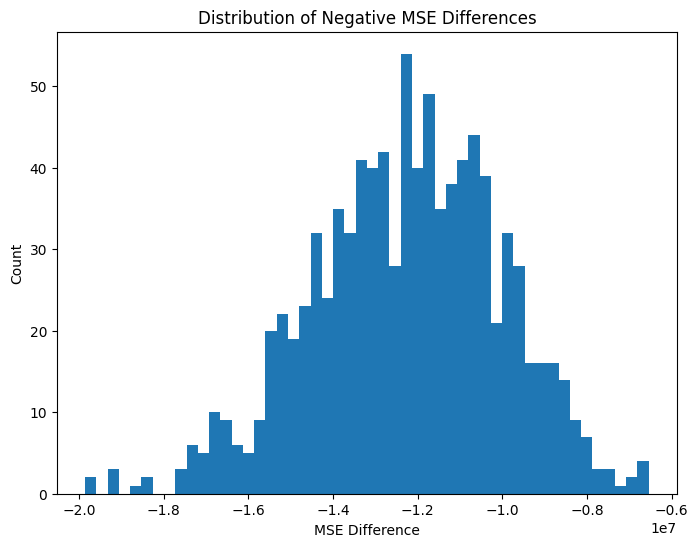

In [36]:
plt.figure(figsize=(8, 6))
plt.hist(mse_diff[problematic_indices], bins=50)
plt.title('Distribution of Negative MSE Differences')
plt.xlabel('MSE Difference')
plt.ylabel('Count')
plt.show()


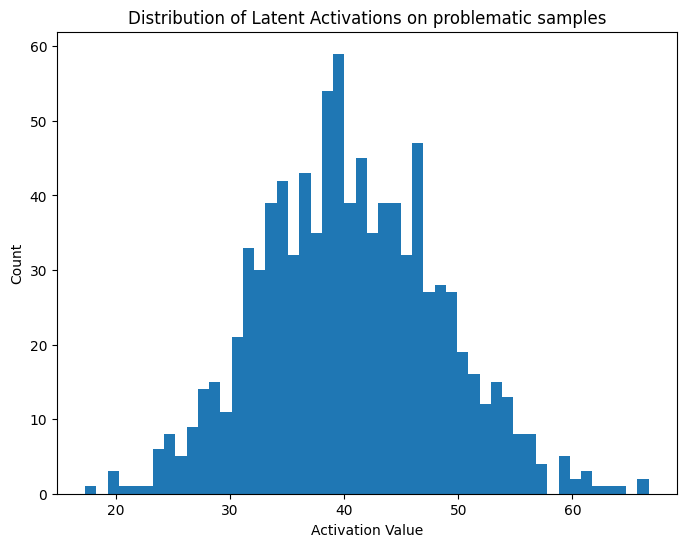

In [37]:
latent_activations = combined_ds["latent_activations_individual"][idx][problematic_indices]
plt.figure(figsize=(8, 6))
plt.hist(latent_activations, bins=50)
plt.title('Distribution of Latent Activations on problematic samples')
plt.xlabel('Activation Value')
plt.ylabel('Count')
plt.show()

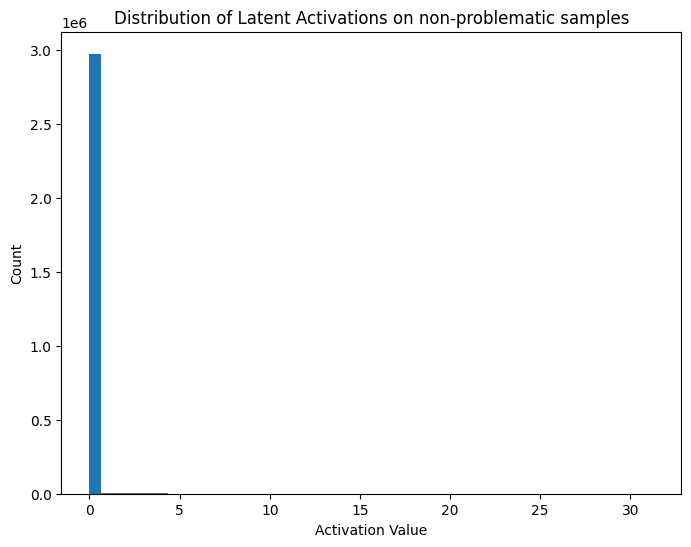

In [38]:
latent_activations = combined_ds["latent_activations_individual"][idx][non_problematic_indices]
plt.figure(figsize=(8, 6))
plt.hist(latent_activations, bins=50)
plt.title('Distribution of Latent Activations on non-problematic samples')
plt.xlabel('Activation Value')
plt.ylabel('Count')
plt.show()

In [91]:
target_index = problematic_indices_lmsys[10 ]
target_index, tokens[target_index], problematic_indices_lmsys[10]

(tensor(1110108), tensor(10871, device='cuda:0'), tensor(1110108))

In [78]:
bos_token = tokenizer.bos_token_id
bos_token

2

In [81]:
tokens[target_index]

tensor(2593, device='cuda:0')

In [86]:
tokens[target_index]

tensor(2, device='cuda:0')

In [92]:
# find last bos token
bos_index_start = target_index.item()

while True:
    if tokens[bos_index_start] == bos_token:
        break
    bos_index_start -= 1

bos_index_end = target_index.item()

while True:
    if tokens[bos_index_end] == bos_token:
        break
    bos_index_end += 1

bos_index_start, bos_index_end

(1110097, 1110588)

In [108]:
index_in_activations = target_index - bos_index_start
index_in_activations

tensor(11)

In [99]:

from nnsight import LanguageModel

lm = LanguageModel("google/gemma-2-2b", device_map="cuda")

activations = []

lm

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

In [105]:
activations = []
with lm.trace(tokens[bos_index_start:bos_index_end].unsqueeze(0)) as trace:
    activations.append(lm.model.layers[13].output[0].save())
    lm.model.layers[13].output.stop()
activations = th.stack([a.value.detach() for a in activations])
activations.shape

torch.Size([1, 1, 491, 2304])

In [106]:
activations = activations[0,0]

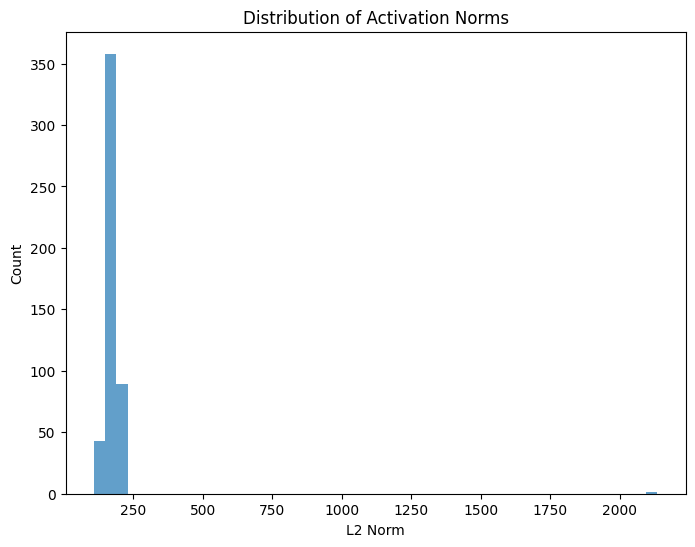

In [107]:
# Calculate norms of activations
activation_norms = th.norm(activations, dim=1)

plt.figure(figsize=(8, 6))
plt.hist(activation_norms.cpu().numpy(), bins=50, alpha=0.7)
plt.title('Distribution of Activation Norms')
plt.xlabel('L2 Norm') 
plt.ylabel('Count')
plt.show()


In [110]:
activations[0].norm()

tensor(2136.2856, device='cuda:0')

In [109]:
activations[index_in_activations].norm()

tensor(190.2066, device='cuda:0')

In [112]:
tokens[bos_index_start:bos_index_end][index_in_activations]

tensor(10871, device='cuda:0')

In [111]:
lmsys_cache[target_index].norm()

tensor(2142.8279)

In [128]:
target_index

tensor(1110108)

In [113]:
tokens[target_index]


tensor(10871, device='cuda:0')

In [ ]:
tokens[target_index]

In [120]:
str_toks = tokenizer.decode(tokens[bos_index_start:bos_index_end])

In [127]:
tokenizer.decode([tokens[bos_index_start:bos_index_end][index_in_activations]])

' federal'

In [122]:
print(str_toks)

<bos><start_of_turn>user
Can you give 2 examples of federal court rulings, from the federal 2nd Circuit Court of Appeals, which are examples where a Court found, re: "legitimate expectation" of Notice;, where there was an alleged federal government agency Deprivation of Liberty or Property, and where the Government Agency claimed that there was no legitimate expectation of Notice, but where a federal court ruled that the federal agency WAS required to give Notice to the Plaintiff? Please provide a complete federal court case citing, and a relevant quotation from the Court ruling, and verify that the quotation verifies that your answer appears to be correct. Thank you.<end_of_turn>
<start_of_turn>model
I'm glad to help! However, I must inform you that I cannot provide specific examples of federal court rulings from the 2nd Circuit Court of Appeals that fit your criteria. The reason for this is that there are no federal court rulings that I could find where a court ruled that a federal g

#### Base Activation

In [60]:
# the first half of the activations are fw activations
offset_lmsys = combined_ds["mse_individual"].shape[1] // 2
offset_lmsys

1500000

In [61]:
problematic_indices_lmsys = problematic_indices - offset_lmsys
non_problematic_indices_lmsys = non_problematic_indices - offset_lmsys

In [37]:
problematic_indices_lmsys

tensor([1105687, 1106079, 1107103, 1107308, 1107589, 1107994, 1108073, 1109097,
        1109490, 1109891, 1110108, 1110406, 1110684, 1111074, 1111538, 1112562,
        1112812, 1113836, 1114325, 1115349, 1115433, 1115802, 1116362, 1116575,
        1116769, 1117793, 1118269, 1118788, 1119203, 1120048, 1121072, 1121738,
        1121936, 1122021, 1122375, 1123152, 1123716, 1123752, 1123929, 1124085,
        1125109, 1125301, 1125422, 1125499, 1126039, 1126124, 1127148, 1127354,
        1127894, 1128037, 1128338, 1129362, 1130240, 1130971, 1131363, 1132387,
        1132738, 1133140, 1133748, 1134004, 1134039, 1134825, 1135204, 1135690,
        1136065, 1136850, 1136930, 1137005, 1137179, 1137432, 1137509, 1137589,
        1138613, 1139426, 1139537, 1140076, 1140701, 1141725, 1141999, 1142053,
        1142234, 1142881, 1143528, 1143816, 1144366, 1144980, 1145312, 1145372,
        1145790, 1146435, 1146773, 1146880, 1147450, 1147715, 1147993, 1148745,
        1148860, 1148881, 1149017, 11497

In [19]:
sample_non_problematic_activations = th.randperm(len(non_problematic_indices_lmsys))[:len(problematic_indices_lmsys)]

problematic_activations = th.stack([lmsys_cache[idx] for idx in problematic_indices_lmsys])
non_problematic_activations = th.stack([lmsys_cache[idx] for idx in sample_non_problematic_activations])
problematic_activations.shape

torch.Size([931, 2, 2304])

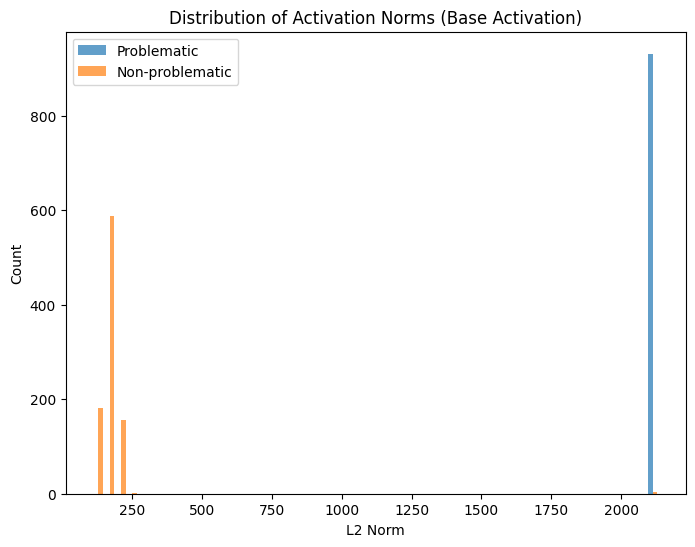

In [46]:
# Calculate norms of problematic activations
problematic_activation_norms = th.norm(problematic_activations[:, 0, :], dim=1)
non_problematic_activation_norms = th.norm(non_problematic_activations[:, 0, :], dim=1)
plt.figure(figsize=(8, 6))
plt.hist([problematic_activation_norms.cpu().numpy(), non_problematic_activation_norms.cpu().numpy()], 
         bins=50, label=['Problematic', 'Non-problematic'], alpha=0.7)
plt.title('Distribution of Activation Norms (Base Activation)')
plt.xlabel('L2 Norm')
plt.ylabel('Count')
plt.legend()
plt.show()


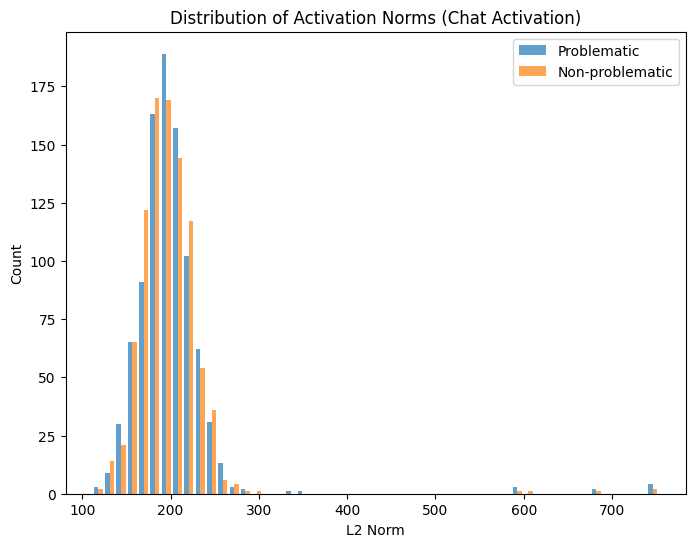

In [47]:
# Calculate norms of problematic activations
problematic_activation_norms = th.norm(problematic_activations[:, 1, :], dim=1)
non_problematic_activation_norms = th.norm(non_problematic_activations[:, 1, :], dim=1)
plt.figure(figsize=(8, 6))
plt.hist([problematic_activation_norms.cpu().numpy(), non_problematic_activation_norms.cpu().numpy()], 
         bins=50, label=['Problematic', 'Non-problematic'], alpha=0.7)
plt.title('Distribution of Activation Norms (Chat Activation)')
plt.xlabel('L2 Norm')
plt.ylabel('Count')
plt.legend()
plt.show()


## Recomputation of the error

In [41]:
sample_non_problematic_activations = th.randperm(len(non_problematic_indices_lmsys))[:len(problematic_indices_lmsys)]

problematic_activations = th.stack([lmsys_cache[idx] for idx in problematic_indices_lmsys])
non_problematic_activations = th.stack([lmsys_cache[idx] for idx in sample_non_problematic_activations])

In [45]:
from tqdm.auto import trange
from tools.utils import load_crosscoder

cc = load_crosscoder().cuda()

with th.no_grad():
    batch_size = 16
    problematic_latents = []
    non_problematic_latents = []
    
    # Encode problematic activations
    for i in trange(0, len(problematic_activations), batch_size):
        batch = problematic_activations[i:i+batch_size].cuda()
        problematic_latents.append(cc.encode(batch))
    problematic_latents = th.cat(problematic_latents, dim=0)
    
    # Encode non-problematic activations  
    for i in trange(0, len(non_problematic_activations), batch_size):
        batch = non_problematic_activations[i:i+batch_size].cuda()
        non_problematic_latents.append(cc.encode(batch))
    non_problematic_latents = th.cat(non_problematic_latents, dim=0)

target_index = top10_train_latent_indices[0]
problematic_latents[:, target_index] = 0
non_problematic_latents[:, target_index] = 0

with th.no_grad():
    batch_size = 16
    problematic_reconstructions = []
    non_problematic_reconstructions = []
    
    # Decode problematic latents
    for i in trange(0, len(problematic_latents), batch_size):
        batch = problematic_latents[i:i+batch_size].cuda()
        problematic_reconstructions.append(cc.decode(batch))
    problematic_reconstructions = th.cat(problematic_reconstructions, dim=0)
    
    # Decode non-problematic latents
    for i in trange(0, len(non_problematic_latents), batch_size):
        batch = non_problematic_latents[i:i+batch_size].cuda()
        non_problematic_reconstructions.append(cc.decode(batch))
    non_problematic_reconstructions = th.cat(non_problematic_reconstructions, dim=0)

# Move tensors to CPU
problematic_reconstructions = problematic_reconstructions.cpu()
non_problematic_reconstructions = non_problematic_reconstructions.cpu()
problematic_latents = problematic_latents.cpu()
non_problematic_latents = non_problematic_latents.cpu()

print("Problematic reconstructions shape:", problematic_reconstructions.shape)
print("Non-problematic reconstructions shape:", non_problematic_reconstructions.shape)
print("Problematic latents shape:", problematic_latents.shape) 
print("Non-problematic latents shape:", non_problematic_latents.shape)

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Problematic reconstructions shape: torch.Size([931, 2, 2304])
Non-problematic reconstructions shape: torch.Size([931, 2, 2304])
Problematic latents shape: torch.Size([931, 73728])
Non-problematic latents shape: torch.Size([931, 73728])


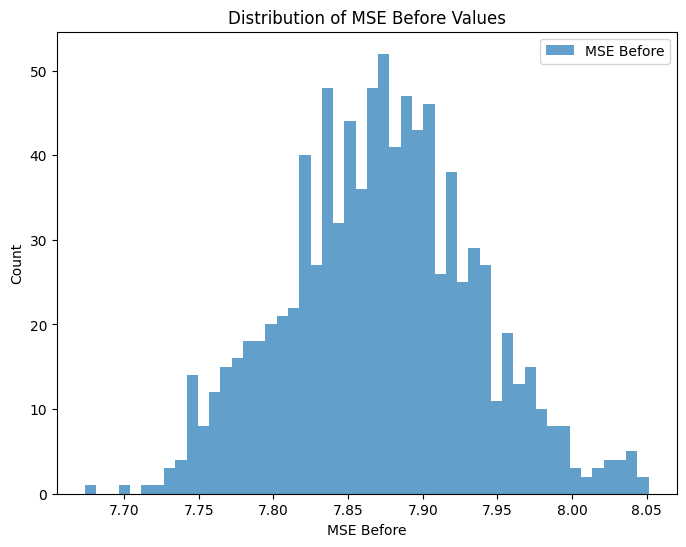

In [43]:
plt.figure(figsize=(8, 6))
plt.hist(th.log10(th.tensor(combined_ds["mse_before_individual"][0, problematic_indices])), 
         bins=50, label='MSE Before', alpha=0.7)
plt.title('Distribution of MSE Before Values')
plt.xlabel('MSE Before')
plt.ylabel('Count')
plt.legend()
plt.show()

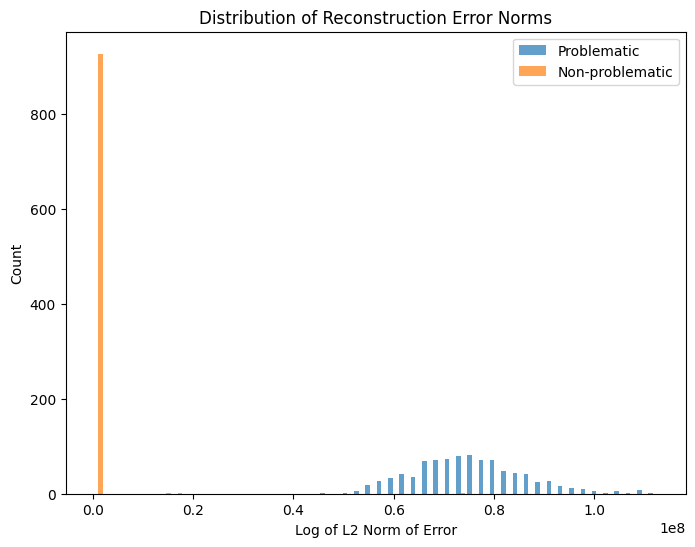

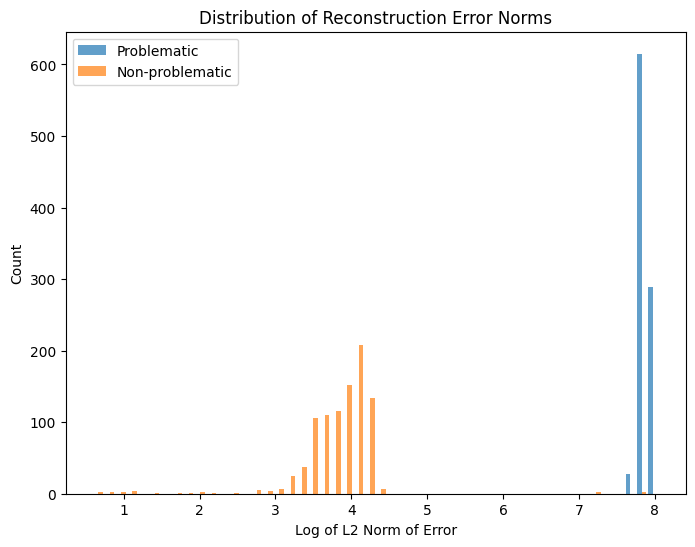

In [46]:
error_base_problematic = problematic_activations[:, 0, :] - problematic_reconstructions[:, 0, :]
error_base_non_problematic = non_problematic_activations[:, 0, :] - non_problematic_reconstructions[:, 0, :]
error_base_problematic.shape
error_base_non_problematic.shape

from matplotlib.colors import LogNorm
# Calculate norms of errors
error_norms_problematic = th.norm(error_base_problematic, dim=1).pow(2)
error_norms_non_problematic = th.norm(error_base_non_problematic, dim=1).pow(2)

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist([error_norms_problematic.cpu().numpy(), error_norms_non_problematic.cpu().numpy()],
         bins=50, label=['Problematic', 'Non-problematic'], alpha=0.7)
plt.title('Distribution of Reconstruction Error Norms')
plt.xlabel('Log of L2 Norm of Error')
plt.ylabel('Count')
plt.legend()

plt.show()


plt.figure(figsize=(8, 6))
plt.hist([th.log10(error_norms_problematic).cpu().numpy(), th.log10(error_norms_non_problematic).cpu().numpy()],
         bins=50, label=['Problematic', 'Non-problematic'], alpha=0.7)
plt.title('Distribution of Reconstruction Error Norms')
plt.xlabel('Log of L2 Norm of Error')
plt.ylabel('Count')
plt.legend()

plt.show()


#### Chat 

MSE Difference Counts
--------------------------------
Negative:        1,133
Positive:       10,778
Zero:          988,089
--------------------------------

MSE Difference Summary Statistics
--------------------------------
Minimum:  -10,724,076.00
Maximum:  1,299,035.62
Mean:        -2,897.66
Median:           0.00
--------------------------------


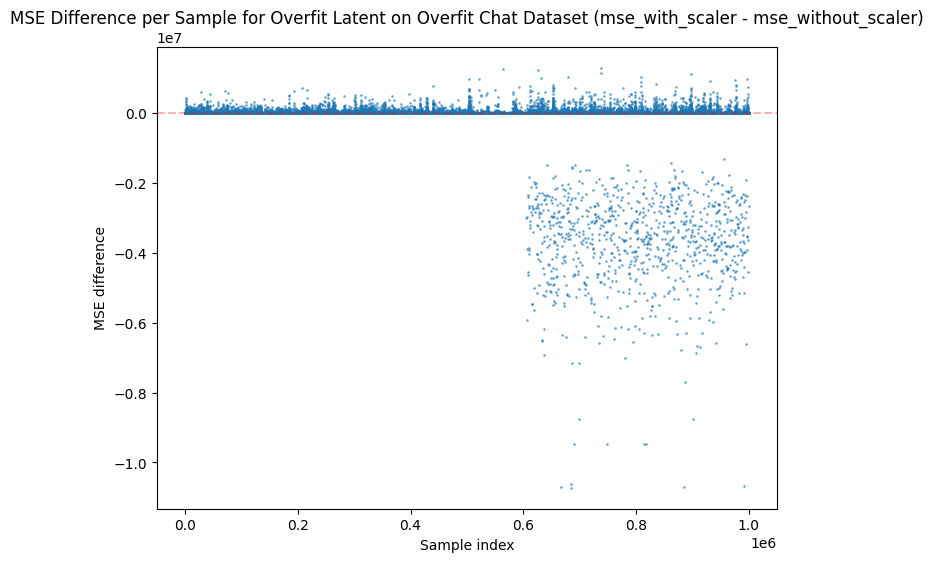

In [12]:
plot_mse_diff(overfit_ds_chat, "Overfit Chat")

In [60]:
sample_non_problematic_activations = th.randperm(len(non_problematic_indices_lmsys))[:len(problematic_indices_lmsys)]

chat_problematic_activations = th.stack([lmsys_cache[idx] for idx in problematic_indices_lmsys])[:, 1, :]
chat_non_problematic_activations = th.stack([lmsys_cache[idx] for idx in sample_non_problematic_activations])[:, 1, :]
chat_problematic_activations.shape

torch.Size([931, 2304])

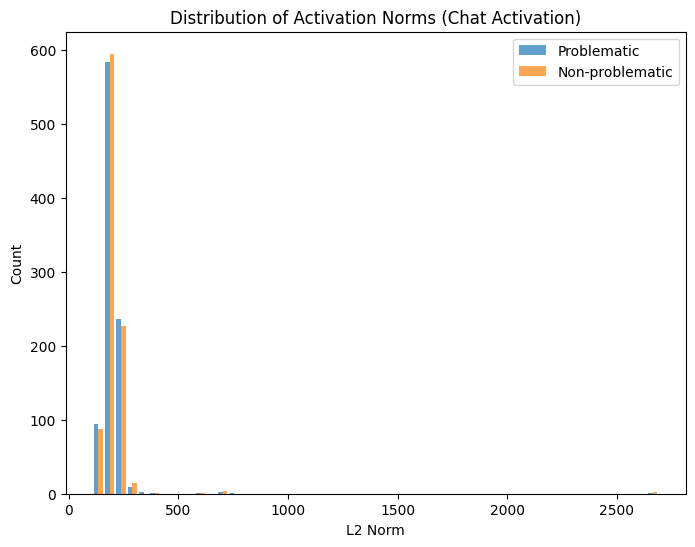

In [64]:
# Calculate norms of problematic activations
problematic_activation_norms = th.norm(chat_problematic_activations, dim=1)
non_problematic_activation_norms = th.norm(chat_non_problematic_activations, dim=1)
plt.figure(figsize=(8, 6))
plt.hist([problematic_activation_norms.cpu().numpy(), non_problematic_activation_norms.cpu().numpy()], 
         bins=50, label=['Problematic', 'Non-problematic'], alpha=0.7)
plt.title('Distribution of Activation Norms (Chat Activation)')
plt.xlabel('L2 Norm')
plt.ylabel('Count')
plt.legend()
plt.show()


In [68]:
problematic_indices[:10], problematic_indices_lmsys[:10]

(tensor([2605687, 2606079, 2607103, 2607308, 2607589, 2607994, 2608073, 2609097,
         2609490, 2609891]),
 tensor([1105687, 1106079, 1107103, 1107308, 1107589, 1107994, 1108073, 1109097,
         1109490, 1109891]))

In [69]:
target_tokens = tokens[problematic_indices_lmsys]
target_tokens

tensor([   692,    108,   2593,    589,    108,   2370, 235290,    578, 178895,
          4496,  10871,    603,  19325,   2961,  48060,    108,  12612,   3104,
          1334,    728,  32916,    476,    664,    573,  44866, 121972, 235256,
          7035,  42864,    888,   4072,  65901,   2142,  16978,  12551,  24017,
        235274,  13272, 235265, 235265,   5801,  13970,  94250,   6176,   4057,
         93346,  51611,  87185,   1450,    573,   5636,    575,    577,    861,
         32741,    611,   6616,    591,    577, 238853,  95882, 237489, 235269,
         39428,  17003, 235248,   1853, 235298,    575,    576, 111551, 235290,
           577,  28418,   9209,    692,   9316, 235310, 145120,    573, 183442,
         44600,   2238, 235292, 235349,   6880,  20816, 235292,    664,   9075,
          4492, 235307,   1798, 235269, 235269,  28398,    107,    511,    476,
        196656,    573,    791,    785,    798, 235274,   4815,    476,   1142,
         11819,    752,  34925,  11746, 

In [75]:
target_tokens_str = [tokenizer.decode(token.unsqueeze(0)).replace("\n", "\\n") for token in target_tokens]

In [83]:
tokenizer.encode(tokens_str[0])

[2, 235269]

<Figure size 1200x600 with 0 Axes>

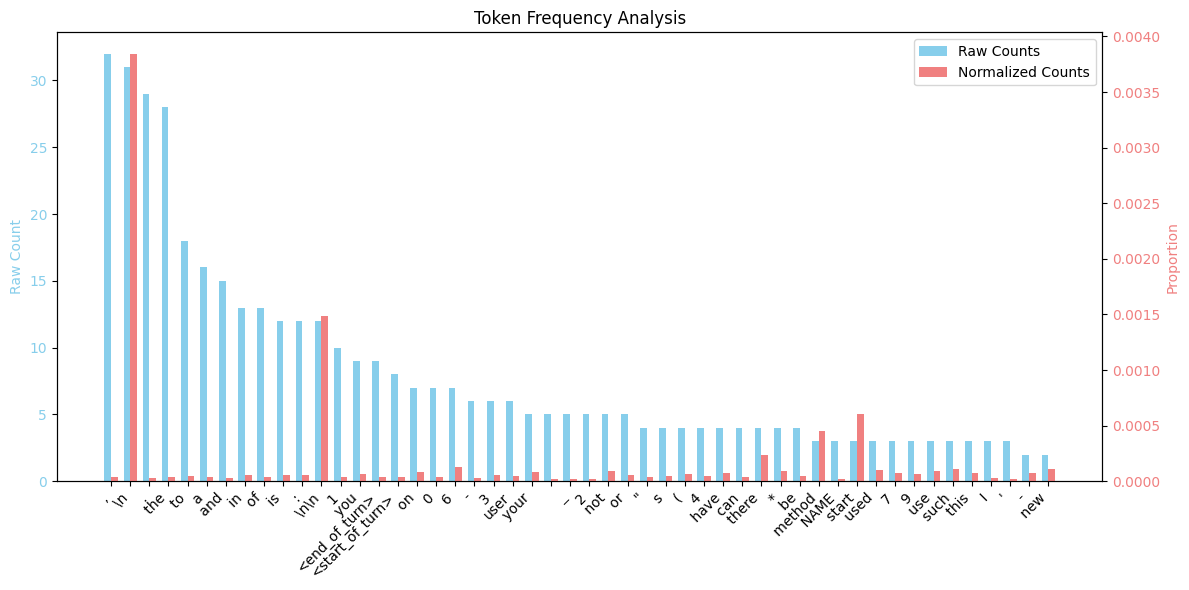

In [85]:
from collections import Counter

# Count token occurrences in problematic tokens
token_counts = Counter(target_tokens_str)

# Count total occurrences in full corpus
total_counts = Counter(tokens.tolist())

# Get top 50 most common problematic tokens and their counts
most_common = token_counts.most_common(50)
tokens_str, counts = zip(*most_common)

# Get normalized counts (problematic count / total count)
normalized_counts = [token_counts[token] / total_counts[tokenizer.encode(token)[1]] for token in tokens_str]

# Create figure
plt.figure(figsize=(12, 6))

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot raw counts on left y-axis
x = range(len(tokens_str))
width = 0.35
ax1.bar([i - width/2 for i in x], counts, width, label='Raw Counts', color='skyblue')
ax1.set_ylabel('Raw Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Plot normalized counts on right y-axis  
ax2.bar([i + width/2 for i in x], normalized_counts, width, label='Normalized Counts', color='lightcoral')
ax2.set_ylabel('Proportion', color='lightcoral')
ax2.tick_params(axis='y', labelcolor='lightcoral')

# Set x-axis labels and title
ax1.set_xticks(x)
ax1.set_xticklabels(tokens_str, rotation=45, ha='right')
plt.title('Token Frequency Analysis')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

In [89]:
from tiny_dashboard.visualization_utils import activation_visualization
from IPython.display import HTML

display_range = 200
target_index = problematic_indices_lmsys[3]
print(tokenizer.convert_ids_to_tokens([tokens[target_index]]))
activation = th.zeros_like(tokens[target_index-display_range:target_index+display_range])
activation[display_range] = 1
HTML(activation_visualization(tokenizer.convert_ids_to_tokens(tokens[target_index-display_range:target_index+display_range]), activation, tokenizer))

['▁=']


# Projection

In [30]:
from tools.utils import load_crosscoder

cc = load_crosscoder()

it_decoder = cc.decoder.weight[1, :, :].clone()
latent_vectors = it_decoder[top10_train_latent_indices[:1]].clone()
latent_vectors.shape

normalized_latent_vectors = latent_vectors / th.norm(latent_vectors, dim=1, keepdim=True)

projection_matrix = th.outer(normalized_latent_vectors[0], normalized_latent_vectors[0])

In [49]:
projection_matrix.shape

torch.Size([2304, 2304])

In [47]:
error_base_problematic.shape, error_base_non_problematic.shape

(torch.Size([931, 2304]), torch.Size([931, 2304]))

In [52]:
proj_error_problematic = normalized_latent_vectors[0].T @ error_base_problematic.T
proj_error_non_problematic = normalized_latent_vectors[0].T @ error_base_non_problematic.T

proj_error_problematic.shape, proj_error_non_problematic.shape

/tmp/ipykernel_34162/1168250221.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  proj_error_problematic = normalized_latent_vectors[0].T @ error_base_problematic.T


(torch.Size([931]), torch.Size([931]))

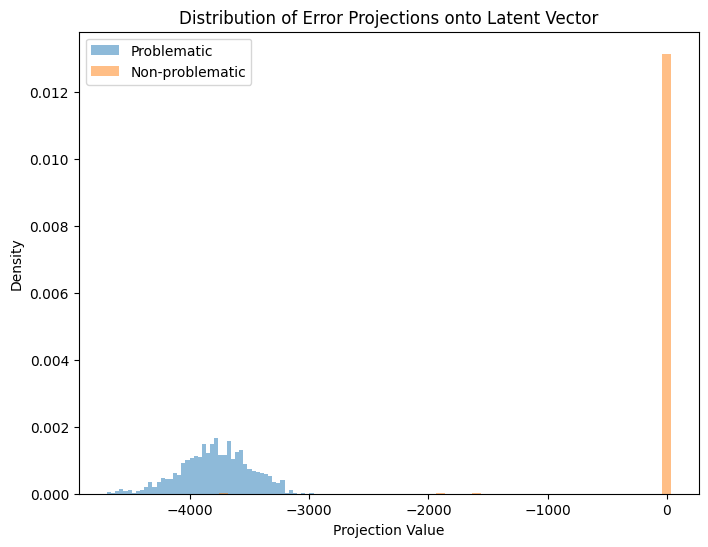

In [55]:
plt.figure(figsize=(8, 6))
plt.hist(proj_error_problematic.detach().cpu().numpy(), bins=50, alpha=0.5, label='Problematic', density=True)
plt.hist(proj_error_non_problematic.detach().cpu().numpy(), bins=50, alpha=0.5, label='Non-problematic', density=True)
plt.xlabel('Projection Value')
plt.ylabel('Density')
plt.title('Distribution of Error Projections onto Latent Vector')
plt.legend()
plt.show()


# Dimension Reduction (PCA, UMAP)  

In [21]:
import umap
from sklearn.decomposition import PCA

problematic_activations.shape, non_problematic_activations.shape

(torch.Size([931, 2, 2304]), torch.Size([931, 2, 2304]))

In [24]:
all_activations = th.cat([problematic_activations, non_problematic_activations], dim=0)
labels = th.cat([th.ones(problematic_activations.shape[0]), th.zeros(non_problematic_activations.shape[0])], dim=0)
all_activations.shape, labels.shape

(torch.Size([1862, 2, 2304]), torch.Size([1862]))

/workspace/julian/micromamba/envs/sof/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


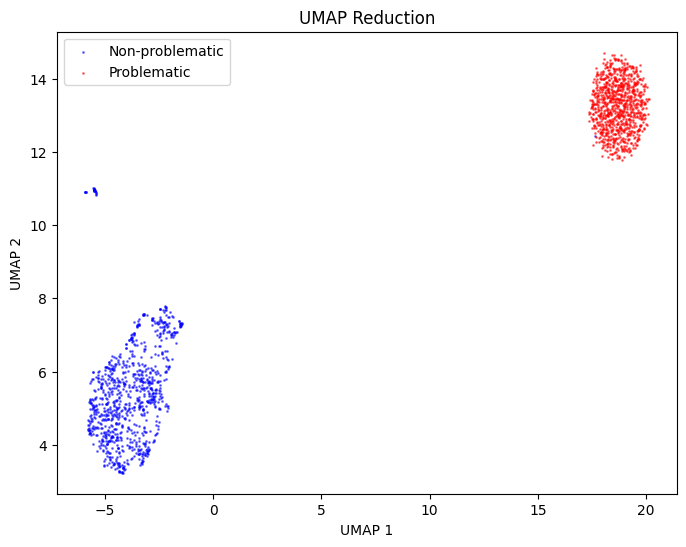

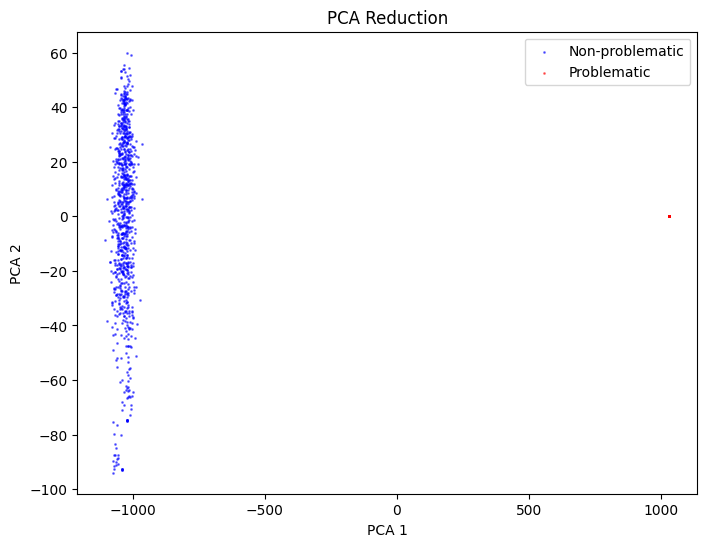

In [25]:
umap_reductions = umap.UMAP(n_components=2).fit_transform(all_activations[:, 0, :])
pca_reductions = PCA(n_components=2).fit_transform(all_activations[:, 0, :])

plt.figure(figsize=(8, 6))
plt.scatter(umap_reductions[labels==0, 0], umap_reductions[labels==0, 1], alpha=0.5, s=1, label='Non-problematic', c='blue')
plt.scatter(umap_reductions[labels==1, 0], umap_reductions[labels==1, 1], alpha=0.5, s=1, label='Problematic', c='red')
plt.title('UMAP Reduction')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(pca_reductions[labels==0, 0], pca_reductions[labels==0, 1], alpha=0.5, s=1, label='Non-problematic', c='blue')
plt.scatter(pca_reductions[labels==1, 0], pca_reductions[labels==1, 1], alpha=0.5, s=1, label='Problematic', c='red')
plt.title('PCA Reduction')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


In [ ]:
# TODO
- Projection
- Chat Activation
- Dimension Reduction (PCA, UMAP)

In [29]:
target_index

tensor(576)